In [99]:
#only (patient_id%NR_SHARDS) == SHARD_ID will be processed here
#choose a value between 1-NR_SHARDS
SHARD_ID = 1
IMAGE_W = 224
IMAGE_H = 152
IMAGE_D = 224
# IMAGE_W = 50
# IMAGE_H = 34
# IMAGE_D = 50

NR_SHARDS = 1
RANDOM_SEED = 0.1

#Patient DICOM images folder
# INPUT_FOLDER = 'output/'
INPUT_FOLDER = '../../input/sample_images/'
OUTPUT_FOLDER = '../../output/step3/' + str(SHARD_ID) + '/'
LABELS_FILE = '../../input/sample_labels.csv'
# LABELS_FILE = 'sample_labels-output.csv'

In [57]:
# %matplotlib inline
# %pylab inline
# plt.ion()

import csv
import h5py
from random import shuffle
import numpy as np # linear algebra
from numpy import ndarray
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statistics
import csv
import dicom
import math
from time import time
import os
import shutil
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.ndimage as ndimage
from scipy.ndimage.interpolation import rotate
from scipy.ndimage.interpolation import shift
import itertools
from itertools import product, combinations
from skimage import measure, morphology, transform
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [58]:
class Timer:
    def __init__(self, name, debug=True):
        self._name = name
        self._debug = debug
        self.start()
    
    def start(self):
        self._start = time()
        if(self._debug):
            log('> [started] ' + self._name + '...')

    def stop(self):
        self._lastElapsed = (time()-self._start)
        if(self._debug):
            log('> [done]    {} ({:.3f} ms)'.format(self._name, self._lastElapsed*1000))
            
    def elapsed(self):
        if(self._lastElapsed != None):
            return (self._lastElapsed)
        else:
            return (time()-self._start)
        
import datetime
def log(message):
    print('{} {}'.format(datetime.datetime.now(), message))


In [59]:
def show_image(pixels, slice_pos):
    fig1, ax1 = plt.subplots(1)
    fig1.set_size_inches(4,4)
    ax1.imshow(pixels[round(np.shape(pixels)[0]*(slice_pos-1))], cmap=plt.cm.gray)
    plt.show()


In [60]:
def show_slices(pixels, nr_slices=12, cols=4):
    fig = plt.figure()
    slice_depth = round(np.shape(pixels)[0]/nr_slices)
    rows = round(nr_slices/cols)+1
    fig.set_size_inches(cols*10, rows*10)
    for i in range(nr_slices):
        slice_pos = int(slice_depth*i)
        y = fig.add_subplot(rows,cols,i+1)
        y.imshow(pixels[slice_pos], cmap='gray')
    plt.show()


In [94]:
# Load the scans in given folder path
#image pixels dimensions: z, y, x
def load_scan(path):
    t = Timer('load_scan ' + path)
    
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.slice_thickness = slice_thickness

    t.stop()
    return slices

#image pixels dimensions: z, y, x
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

#image pixels dimensions: z, y, x
def resample(image, scan, new_spacing=[1,1,1]):
    t = Timer('resample')
    # Determine current pixel spacing
    spacing = np.array([scan[0].slice_thickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    t.stop()
    
    return image, new_spacing

def largest_label_volume(im, bgs=[]):
    vals, counts = np.unique(im, return_counts=True)
    for bg in bgs:
        counts = counts[vals != bg]
        vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
    
def segment_lung_mask(image, fill_lung_structures=True):
    t = Timer('segment_lung_mask')

#     show_slices(image)
    
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    
    #avoid small holes between lung and external body due to cropped scans
    print('1')
#     binary_image = scipy.ndimage.morphology.grey_dilation(binary_image, 2)
    
    #cleanup some small bubbles inside body before labelling
    print('2')
    binary_image = scipy.ndimage.morphology.grey_closing(binary_image, 3)
#     show_slices(binary_image)

    labels = measure.label(binary_image)
#     show_slices(labels)
    
    #discover lung label number by looking at the middle lung slice
    #look inside the volume where lung structures is meant to be
#     lung_label = largest_label_volume(labels[s[0]*0.2:s[0]*0.8, s[1]*0.25:s[1]*0.75, s[2]*0.25:s[2]*0.75], bg=0)
#     air1 = labels[0,0,0]
#     air2 = labels[0,np.shape(labels)[1]-1,0]
    air1 = 0
    air2 = 0
    s = np.array(np.shape(labels))
    body = largest_label_volume(labels[round(s[0]*0.6):round(s[0]*0.64), round(s[1]*0.47):round(s[1]*0.53), 0:s[2]*0.12], bgs=[0, air1, air2])
    bgs = [0, air1, air2, body]
    print('bgs',bgs)

    lung_label = largest_label_volume(labels[s[0]*0.2:s[0]*0.8, s[1]*0.25:s[1]*0.75, s[2]*0.25:s[2]*0.75], bgs=bgs)

    #TEMP
#     lung_label = largest_label_volume(labels[round(s[0]*0.6), round(s[1]*0.5)], bgs=[0, air1, air2])

    print('lung_label',lung_label)

    #remove everything that is not part of the lung
    print('remove non lung structures')
    binary_image[labels != lung_label] = 2
#     show_slices(binary_image)
    
    #Determine which label clusters refers to the air/space around the person body and turn it into the same cluster
    #The various corners are measured in case of volume being broken when the body is not fitted inside scan
#     print('3')
#     si = np.shape(binary_image)
#     si0 = si[0]-3
#     si1 = si[1]-3
#     si2 = si[2]-3
#     for i in (2, si0):
#         for j in (2, si1):
#             for k in (2, si2):
#                 if(labels[i,j,k] != lung_label):
#                     binary_image[labels[i,j,k] == labels] = 2

    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bgs=[0])
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    print('fill_lung_structures')
#     show_slices(binary_image)
    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
#     labels = measure.label(binary_image, background=0)
    
#     l_max = largest_label_volume(labels, bg=0)
#     if l_max is not None: # There are air pockets
#         binary_image[labels != l_max] = 0

    #dilate mask
    binary_image = scipy.ndimage.morphology.grey_dilation(binary_image, size=(10,10,10))
    t.stop()
    
    show_slices(binary_image)
    
    return binary_image

#returns ((x1, y1, z1), (x2, y2, z2))
def bounding_box(img):
    N = img.ndim
    out = []
    for ax in itertools.combinations(range(N), N - 1):
        nonzero = np.any(img, axis=ax)
#         if(np.amin(nonzero)==0):
#             return None
        out.extend(np.where(nonzero)[0][[0, -1]])
    r = np.reshape(np.asarray(tuple(out)), (-1, 2)).T
    return [tuple(r[0]), tuple(r[1])]

#return bounding box center in (x,y,z)
def bounding_box_center(bounds):
    return (int(round((bounds[0][0] + (bounds[1][0]-bounds[0][0])/2))), int(round((bounds[0][1] + (bounds[1][1]-bounds[0][1])/2))), int(round((bounds[0][2] + (bounds[1][2]-bounds[0][2])/2))))


In [85]:
#find lungs rotation by finding minimum and maximum extremities from lung halves
def find_minmax_halfx(lung_mask, xhalf, bottom2up=True, left2right=True, slicen=220):
    xsize = np.shape(lung_mask)[2]-1
    ysize = np.shape(lung_mask)[1]-1
    im = np.swapaxes(lung_mask[slicen], 0, 1)

    if(bottom2up): mvalue = (-1,0)
    else: mvalue = (-1, ysize)
        
    if(left2right): 
        xstart = 0
        xend = xhalf
        xdir = 1
    else:
        xstart = xsize
        xend = xhalf
        xdir = -1
        
    for x in range(xstart, xend, xdir):
        for y in range(ysize):
            if(not bottom2up): yi = ysize - y
            else: yi = y

            if(im[x][yi]>0.5):
                if(bottom2up and yi>mvalue[1]):
                    mvalue = (x, yi)
                elif(not bottom2up and yi<mvalue[1]):
                    mvalue = (x, yi)
    return mvalue
    
def calculate_angle(p1, p2):
    return math.degrees(math.atan2(p2[1]-p1[1],p2[0]-p1[0]))

def value_between(value, min_value, max_value):
    if(value<min_value): return False
    if(value>max_value): return False
    return True

def discover_lung_rotation(lung_mask):
    bbox = bounding_box(lung_mask)
    if(bbox == None): return 0
    slicen = int((bbox[1][2]-bbox[0][2])/2)
    half = int(bbox[0][0]+(bbox[1][0]-bbox[0][0])/2)

    l1 = find_minmax_halfx(lung_mask, half, bottom2up=True, left2right=True, slicen=slicen)
    r1 = find_minmax_halfx(lung_mask, half, bottom2up=True, left2right=False, slicen=slicen)
    l2 = find_minmax_halfx(lung_mask, half, bottom2up=False, left2right=True, slicen=slicen)
    r2 = find_minmax_halfx(lung_mask, half, bottom2up=False, left2right=False, slicen=slicen)

    r = (l1, r1, l2, r2)
    xs, ys = zip(*r)
    
    #verify points sanity
    if(not value_between(xs[1]-xs[0], 50, 200) or
       not value_between(xs[3]-xs[2], 50, 200) or
       not value_between(ys[0]-ys[2], 100, 250) or
       not value_between(ys[1]-ys[3], 100, 250)):
        print('Strange rotation detected. returning 0 degrees')
        return 0
    
    angle1 = calculate_angle(l1, r1)
    angle2 = calculate_angle(l2, r2)
    
#     fig1, ax1 = plt.subplots(1)
#     fig1.set_size_inches(2,2)
#     ax1.imshow(lung_mask[slicen], cmap=plt.cm.gray)
#     ax1.scatter(xs, ys)
#     plt.show()
    
    a = ((angle1 + angle2)/2)
    return min(max(a, -10), 10)

In [86]:
def get_patient_ids(shard_id, input_dir):
    shard_patients = []
    
    file = csv.DictReader(open(LABELS_FILE))    
    for row in file:
        p = row['id']
        if(int(p,16)%NR_SHARDS == (shard_id-1)):
            shard_patients.append(p)
    log('found {} patients for shard {}'.format(len(shard_patients), shard_id))
    shuffle(shard_patients, lambda: RANDOM_SEED)
    return shard_patients

In [87]:
def generate_slice(patient_px, patient_id, slice_pos, output_dir):
    t = Timer('generate_slice ' + str(slice_pos))
    fig1, ax1 = plt.subplots(1)
    fig1.set_size_inches(6,6)
    ax1.imshow(patient_px[slice_pos], cmap=plt.cm.gray)
    file = output_dir + patient_id + '-' + 'slice-' + str(slice_pos) + '.jpg'
    plt.savefig(file)
        
#     plt.close(fig1)
    plt.show()
    t.stop()

In [88]:
def process_patient_label(input_dir, patient_id, output_dataset, dataset_row):
    labels = pd.read_csv(LABELS_FILE, index_col=0)
    value = labels.get_value(patient_id, 'cancer')
    #one-hot encoding
    label = np.array([0,1])
    if(value == 0): label = np.array([1,0])
    output_dataset[dataset_row] = label

In [89]:
def diff_for_shiffiting(point1, point2):
    t = np.subtract(point1, point2)
    return (t[2], t[1], t[0])

In [90]:
def bbox_dim(bbox):
    bw = bbox[1][0]-bbox[0][0]
    bh = bbox[1][1]-bbox[0][1]
    bd = bbox[1][2]-bbox[0][2]
    return bw,bh,bd

In [95]:
def process_patient_images(input_dir, patient_id, image_w, image_h, image_d, output_dataset, dataset_row, output_dir):
    patient_dir = input_dir + patient_id
    patient_scan = load_scan(patient_dir)
    patient_pixels = get_pixels_hu(patient_scan)
    show_image(patient_pixels, 0.5)
    patient_pixels, spacing = resample(patient_pixels, patient_scan, [1,1,1])
#     show_image(patient_pixels, 0.5)
    patient_lung_mask = segment_lung_mask(patient_pixels, True)
    show_image(patient_lung_mask, 0.5)
    
    t = Timer('apply lung mask to image volume')
    patient_pixels = np.ma.masked_where(patient_lung_mask==0, patient_pixels).filled(fill_value=0)
    t.stop()

    t = Timer('rotate image for optimal pose')
    rotation_angle = discover_lung_rotation(patient_lung_mask)
    patient_pixels = rotate(patient_pixels,rotation_angle,(1,2), reshape=False)
    t.stop()
    
    t = Timer('resize image volume to {}x{}x{}'.format(image_w, image_h, image_d))
    bbox = bounding_box(patient_lung_mask)
    if(bbox == None):
        return False
    bw,bh,bd = bbox_dim(bbox)
    fit_volume = (image_w, image_h, image_d)
    ratio = min(tuple(np.divide(fit_volume,np.subtract(bbox[1],bbox[0]))))
    print('ratio=', ratio)
   
    patient_pixels = scipy.ndimage.interpolation.zoom(patient_pixels[bbox[0][2]:bbox[1][2],bbox[0][1]:bbox[1][1],bbox[0][0]:bbox[1][0]], ratio)
    t.stop()

    t = Timer('translate to center')
    fit_volume_center = tuple(np.divide(fit_volume, 2))
    bbox = bounding_box(patient_pixels)
    bbox_center = bounding_box_center(bbox)

    patient_pixels2 = np.full((image_d, image_h, image_w),0)
    ps = np.shape(patient_pixels)
    patient_pixels2[:ps[0],:ps[1],:ps[2]] = patient_pixels[:ps[0],:ps[1],:ps[2]]
    patient_pixels = patient_pixels2
    
    diff = (np.subtract(fit_volume_center,bbox_center))
    patient_pixels = shift(patient_pixels, (diff[2],diff[1],diff[0]))
    t.stop()

    #normalization for better training on neural networks
    t = Timer('pixel normalization')
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    
    patient_pixels = (patient_pixels - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    patient_pixels[patient_pixels>1] = 1.
    patient_pixels[patient_pixels<0] = 0.

    #0-center pixels
    print('mean pixels=',np.mean(patient_pixels))
    PIXEL_MEAN = 0.6 #calculated before
    patient_pixels = patient_pixels - PIXEL_MEAN
    t.stop()
    
    generate_slice(patient_pixels, patient_id, round(np.shape(patient_pixels)[0]/2), output_dir)

    t = Timer('put patient image into dataset')
    output_dataset[dataset_row] = patient_pixels
    t.stop()
    
    return True

In [92]:
def start_processing(input_dir, shard_id, max_patients, image_w, image_h, image_d, output_dir):
    log('Processing patients. shard_id=' + str(shard_id) + ' max_patients='+ str(max_patients) + ' input_dir=' + input_dir + ' output_dir=' + output_dir)
    
    log('Gathering patient ids for this shard')
    patient_ids = get_patient_ids(shard_id, input_dir)
    total_patients = len(patient_ids)
    
    log('Preparing output dir')
    shutil.rmtree(output_dir, True)
    try:
        os.makedirs(output_dir)
    except:
        print('Ops! Couldnt create output dir')
        pass
    
    log('Creating datasets')
    dataset_file = output_dir + 'data-centered-rotated-{}-{}-{}.h5'.format(image_w, image_h, image_d)
    h5f = h5py.File(dataset_file, 'w')
    x_ds = h5f.create_dataset('X', (total_patients, image_d, image_h, image_w), chunks=(1, image_d, image_h, image_w), dtype='f')
    y_ds = h5f.create_dataset('Y', (total_patients, 2), dtype='f')

    log('Starting to process each patient (count={})'.format(len(patient_ids)))
    count = 0
    record_row = 0

    for patient_id in patient_ids:
        if(count>(max_patients-1)):
            break

        t = Timer('>>> PATIENT PROCESSING ' + patient_id + ' (count=' + str(count) + '; output_dir=' + output_dir + ')')
        try:
            r = process_patient_images(input_dir, patient_id, image_w, image_h, image_d, x_ds, record_row, output_dir)
            if(r):
                process_patient_label(input_dir, patient_id, y_ds, record_row)
                record_row = record_row + 1
            else:
                print('Patient lung not found. Skipping.')   
            t.stop()
        except:
            print('!!!! There was a problem processing patient_id=', patient_id)
            pass
        
        count = count + 1
        
    h5f.close()
    
    log('Final dataset status')
    h5f = h5py.File(dataset_file, 'r')
    print('X shape=', h5f['X'].shape)
    print('Y shape=', h5f['Y'].shape)

    show_slices(h5f['X'][count-1])
    
#     fig1, ax1 = plt.subplots(1)
#     fig1.set_size_inches(3,3)
#     ax1.imshow(h5f['X'][count-1][round(image_d/2)], cmap=plt.cm.gray)
#     plt.show()
    
    print(h5f['X'][count-1].shape)
    
    h5f.close()


==== PROCESSING SHARD 1 ====
2017-02-18 21:30:40.429540 Processing patients. shard_id=1 max_patients=99 input_dir=output/ output_dir=../../output/step3/1/
2017-02-18 21:30:40.429574 Gathering patient ids for this shard
2017-02-18 21:30:40.432938 found 8 patients for shard 1
2017-02-18 21:30:40.433314 Preparing output dir
2017-02-18 21:30:40.438432 Creating datasets
2017-02-18 21:30:40.439308 Starting to process each patient (count=8)
2017-02-18 21:30:40.439358 > [started] >>> PATIENT PROCESSING 40c044145f5c87c12bd8c725924add3c (count=0; output_dir=../../output/step3/1/)...
2017-02-18 21:30:40.439402 > [started] load_scan output/40c044145f5c87c12bd8c725924add3c...
2017-02-18 21:30:41.337295 > [done]    load_scan output/40c044145f5c87c12bd8c725924add3c (897.877 ms)


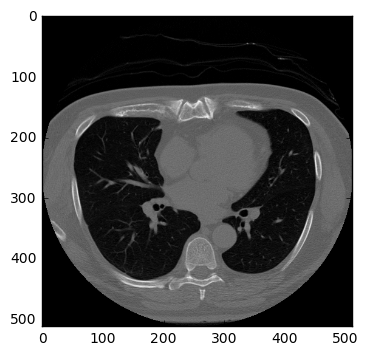

2017-02-18 21:30:41.836391 > [started] resample...
2017-02-18 21:31:02.314497 > [done]    resample (20478.067 ms)
2017-02-18 21:31:02.320111 > [started] segment_lung_mask...
1
2


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:99: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:103: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


bgs [0, 0, 0, 2]
lung_label 29
remove non lung structures
fill_lung_structures
2017-02-18 21:31:09.216423 > [done]    segment_lung_mask (6896.290 ms)


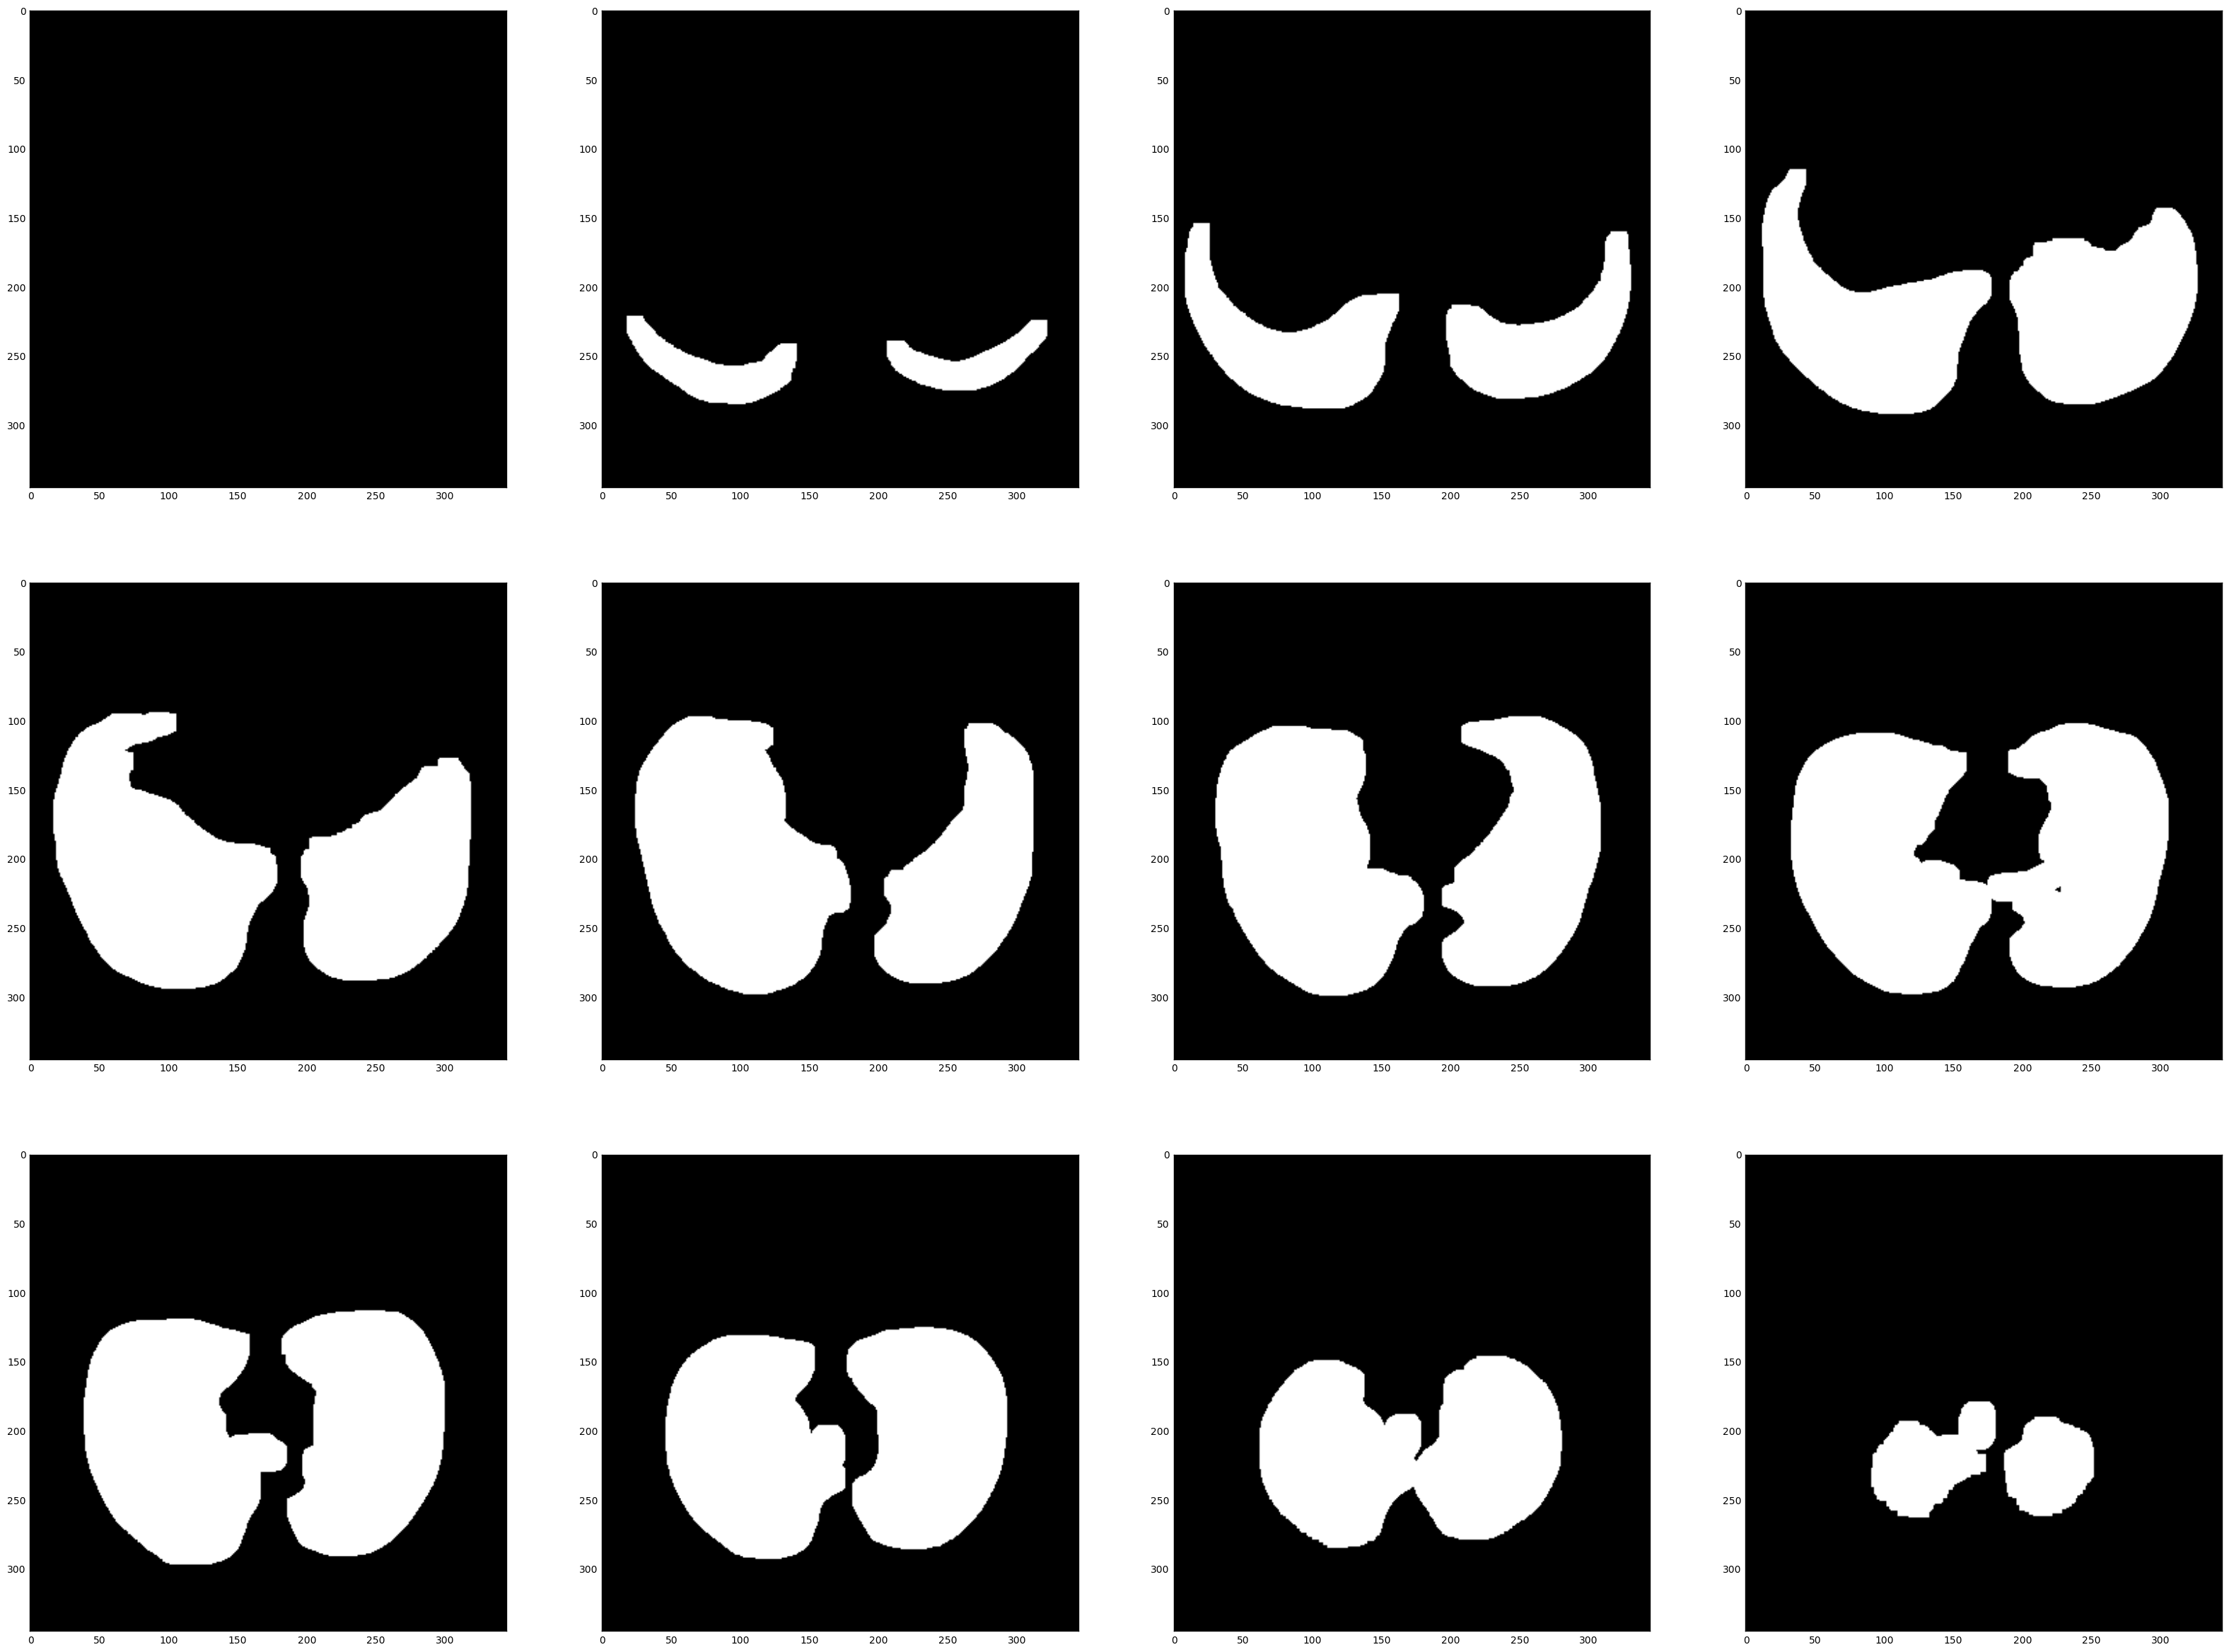

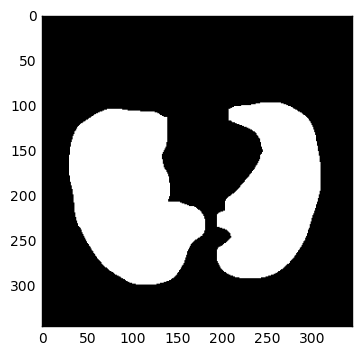

2017-02-18 21:31:14.356306 > [started] apply lung mask to image volume...
2017-02-18 21:31:14.688973 > [done]    apply lung mask to image volume (332.638 ms)
2017-02-18 21:31:14.689130 > [started] rotate image for optimal pose...
2017-02-18 21:31:21.462061 > [done]    rotate image for optimal pose (6772.884 ms)
2017-02-18 21:31:21.462241 > [started] resize image volume to 224x152x224...
ratio= 0.629213483146


/opt/conda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


2017-02-18 21:31:24.502029 > [done]    resize image volume to 224x152x224 (3039.753 ms)
2017-02-18 21:31:24.502185 > [started] translate to center...


/opt/conda/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((224, 152, 224), 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


2017-02-18 21:31:27.068236 > [done]    translate to center (2566.006 ms)
2017-02-18 21:31:27.068418 > [started] pixel normalization...
mean pixels= 0.590748568423
2017-02-18 21:31:27.163004 > [done]    pixel normalization (94.562 ms)
2017-02-18 21:31:27.163088 > [started] generate_slice 112...


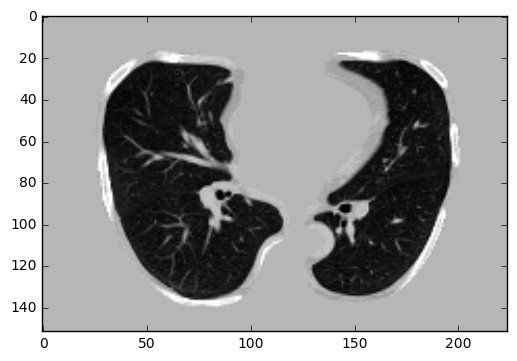

2017-02-18 21:31:27.454573 > [done]    generate_slice 112 (291.470 ms)
2017-02-18 21:31:27.454630 > [started] put patient image into dataset...
2017-02-18 21:31:27.494101 > [done]    put patient image into dataset (39.446 ms)
2017-02-18 21:31:27.511538 > [done]    >>> PATIENT PROCESSING 40c044145f5c87c12bd8c725924add3c (count=0; output_dir=../../output/step3/1/) (47072.163 ms)
2017-02-18 21:31:27.511598 > [started] >>> PATIENT PROCESSING 4b2f615f5498ee9d935b0229a2e6bb19 (count=1; output_dir=../../output/step3/1/)...
2017-02-18 21:31:27.511625 > [started] load_scan output/4b2f615f5498ee9d935b0229a2e6bb19...
2017-02-18 21:31:29.793418 > [done]    load_scan output/4b2f615f5498ee9d935b0229a2e6bb19 (2281.775 ms)


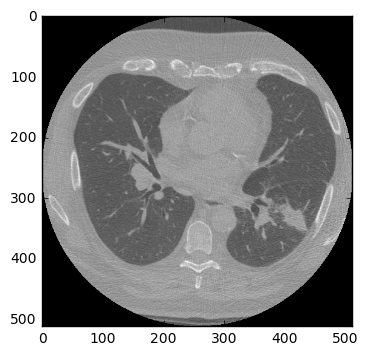

2017-02-18 21:31:30.661224 > [started] resample...
2017-02-18 21:31:51.837181 > [done]    resample (21175.942 ms)
2017-02-18 21:31:51.848152 > [started] segment_lung_mask...
1
2
bgs [0, 0, 0, 2]
lung_label 1
remove non lung structures
fill_lung_structures
2017-02-18 21:31:56.295805 > [done]    segment_lung_mask (4447.629 ms)


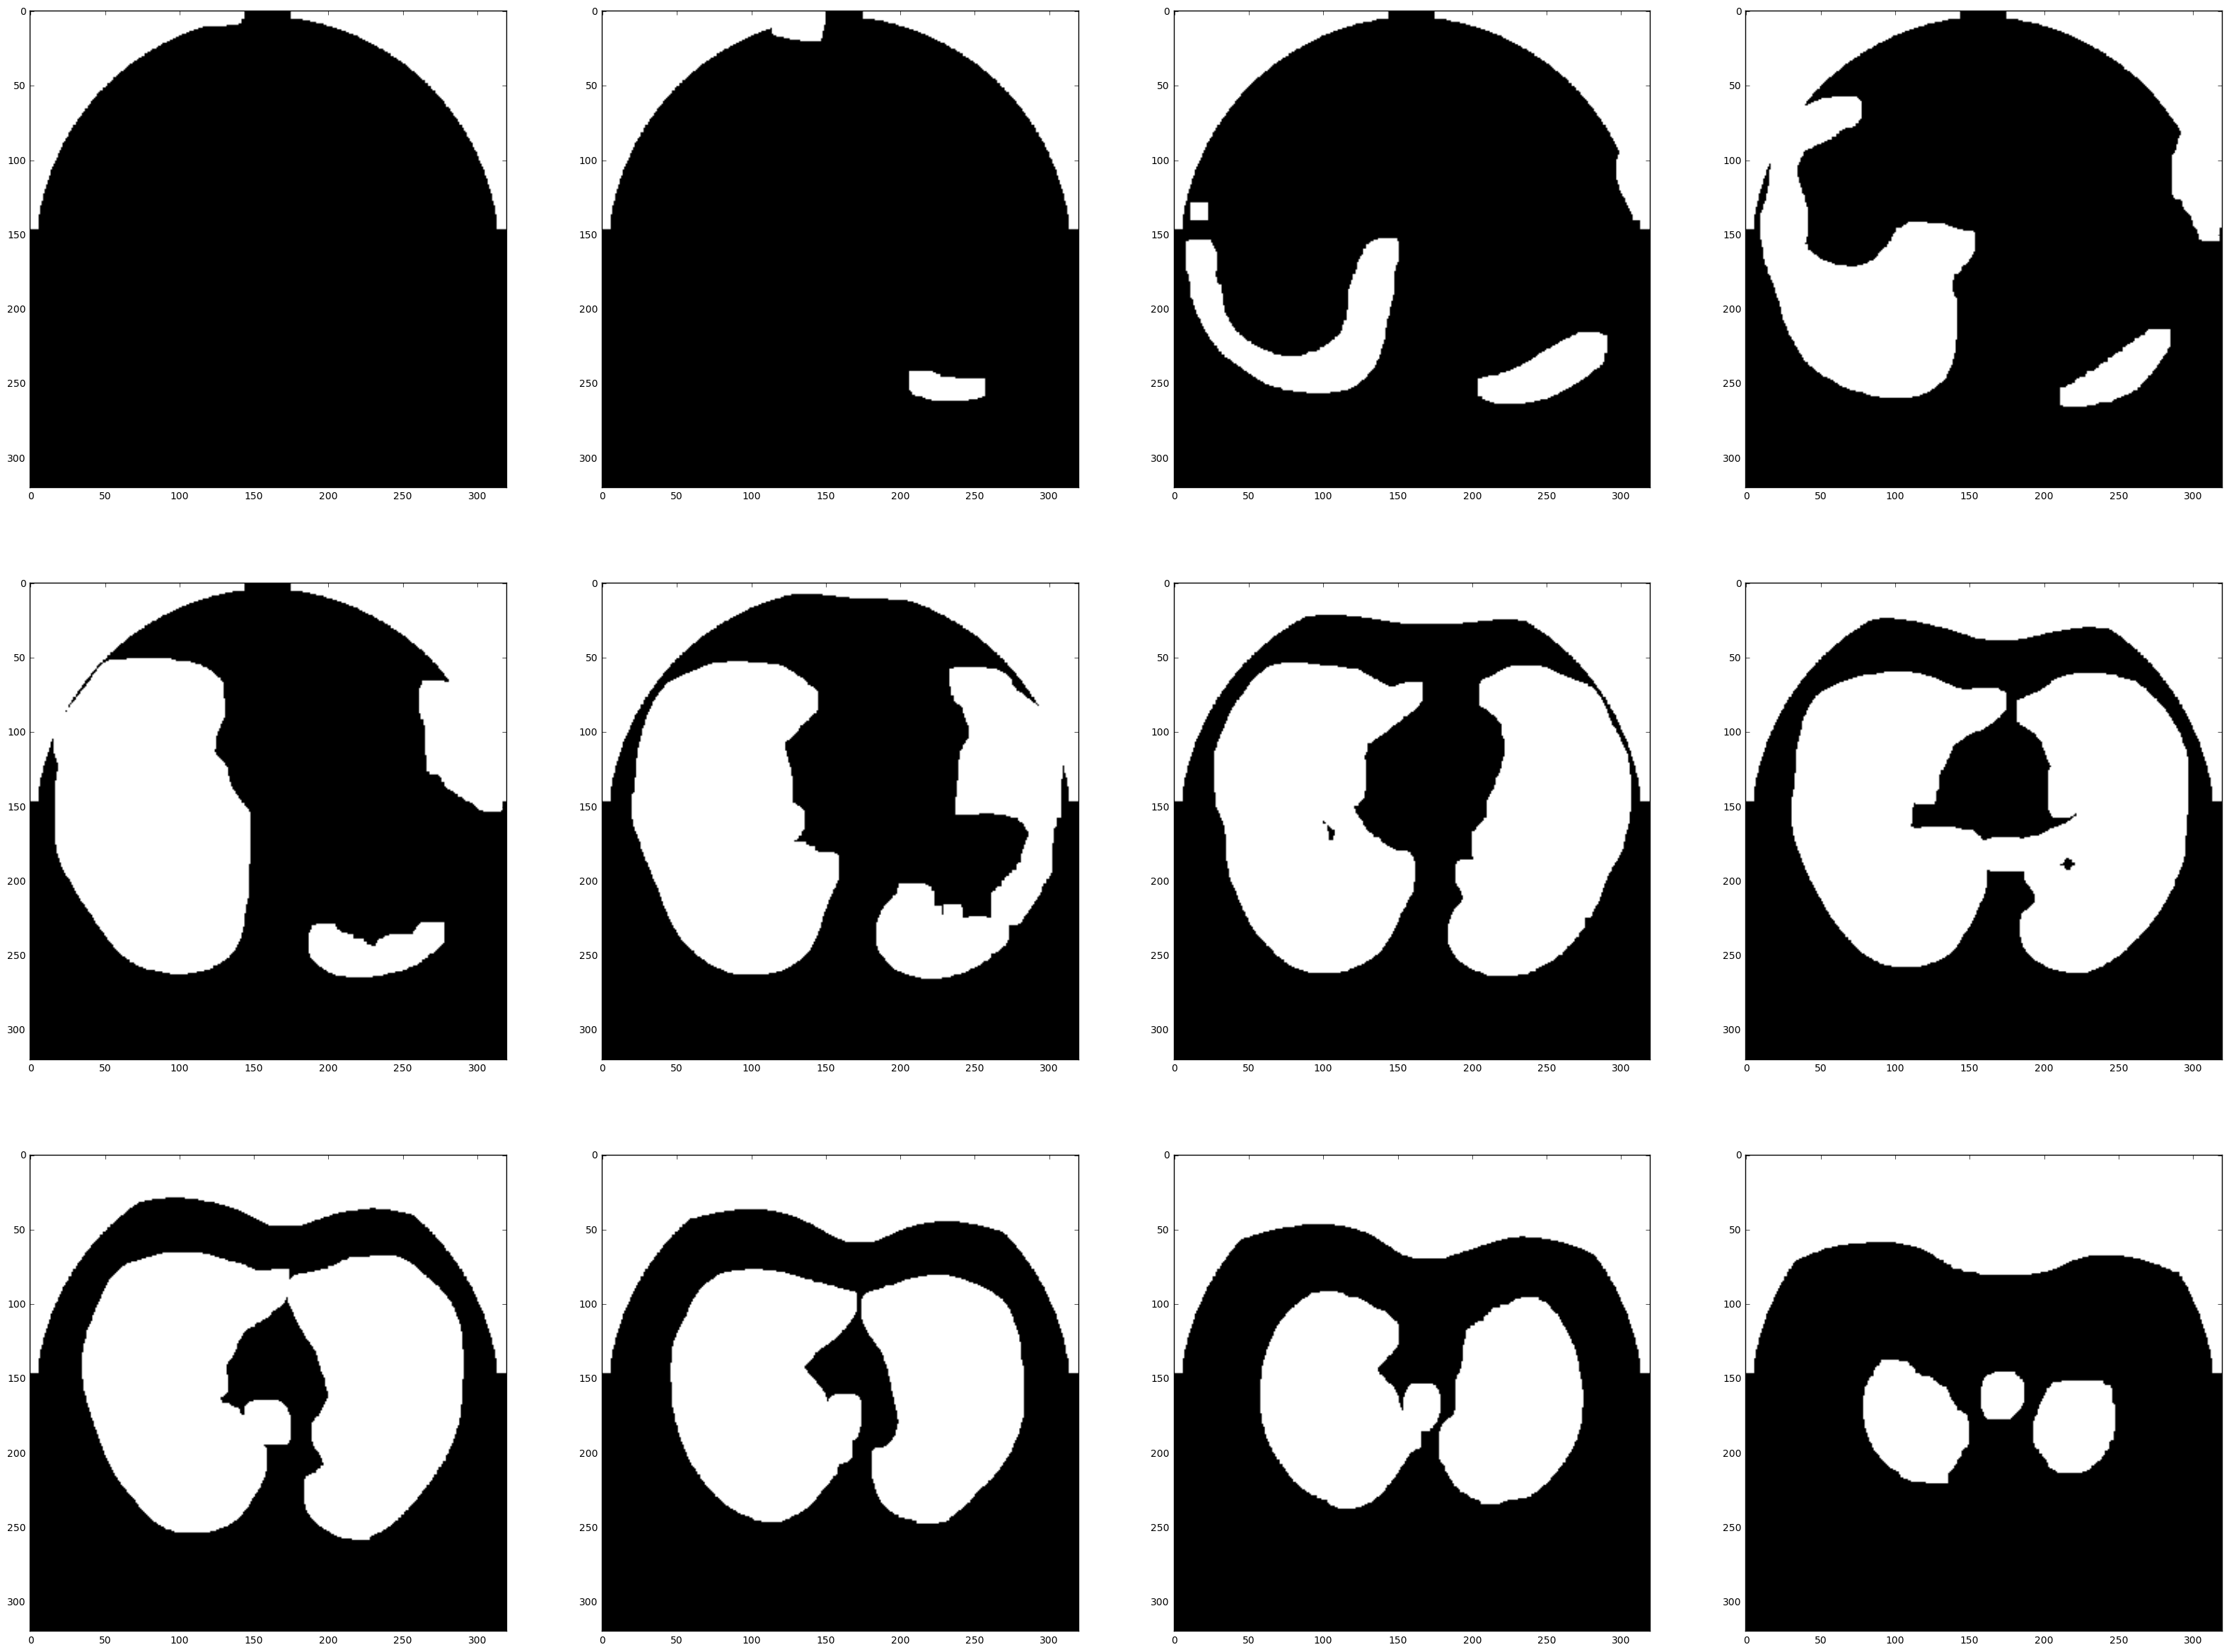

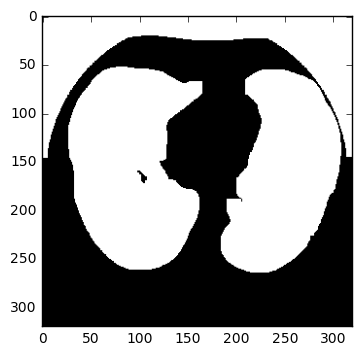

2017-02-18 21:32:01.344751 > [started] apply lung mask to image volume...
2017-02-18 21:32:01.548581 > [done]    apply lung mask to image volume (203.804 ms)
2017-02-18 21:32:01.548664 > [started] rotate image for optimal pose...
Strange rotation detected. returning 0 degrees
2017-02-18 21:32:05.631353 > [done]    rotate image for optimal pose (4082.662 ms)
2017-02-18 21:32:05.631493 > [started] resize image volume to 224x152x224...
ratio= 0.57358490566
2017-02-18 21:32:07.823810 > [done]    resize image volume to 224x152x224 (2192.284 ms)
2017-02-18 21:32:07.823972 > [started] translate to center...
2017-02-18 21:32:10.027739 > [done]    translate to center (2203.730 ms)
2017-02-18 21:32:10.027899 > [started] pixel normalization...
mean pixels= 0.588238720943
2017-02-18 21:32:10.127056 > [done]    pixel normalization (99.127 ms)
2017-02-18 21:32:10.127140 > [started] generate_slice 112...


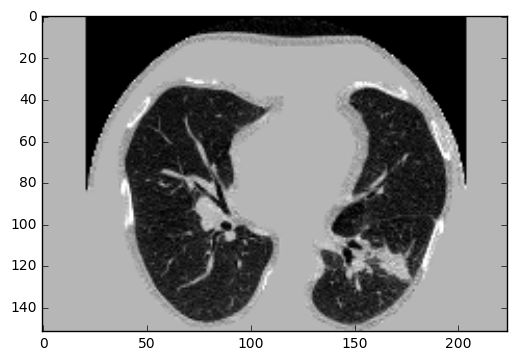

2017-02-18 21:32:10.428351 > [done]    generate_slice 112 (301.194 ms)
2017-02-18 21:32:10.428413 > [started] put patient image into dataset...
2017-02-18 21:32:10.473321 > [done]    put patient image into dataset (44.886 ms)
2017-02-18 21:32:10.492312 > [done]    >>> PATIENT PROCESSING 4b2f615f5498ee9d935b0229a2e6bb19 (count=1; output_dir=../../output/step3/1/) (42980.698 ms)
2017-02-18 21:32:10.492373 > [started] >>> PATIENT PROCESSING 5a42f0a0d1e060531c20d04ed23efc02 (count=2; output_dir=../../output/step3/1/)...
2017-02-18 21:32:10.492401 > [started] load_scan output/5a42f0a0d1e060531c20d04ed23efc02...
2017-02-18 21:32:11.163684 > [done]    load_scan output/5a42f0a0d1e060531c20d04ed23efc02 (671.267 ms)


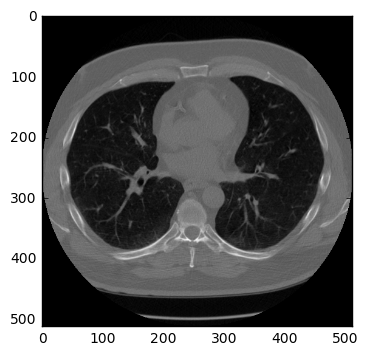

2017-02-18 21:32:11.502239 > [started] resample...
2017-02-18 21:32:29.823163 > [done]    resample (18320.889 ms)
2017-02-18 21:32:29.823465 > [started] segment_lung_mask...
1
2
bgs [0, 0, 0, 3]
lung_label 30
remove non lung structures
fill_lung_structures
2017-02-18 21:32:35.672957 > [done]    segment_lung_mask (5849.448 ms)


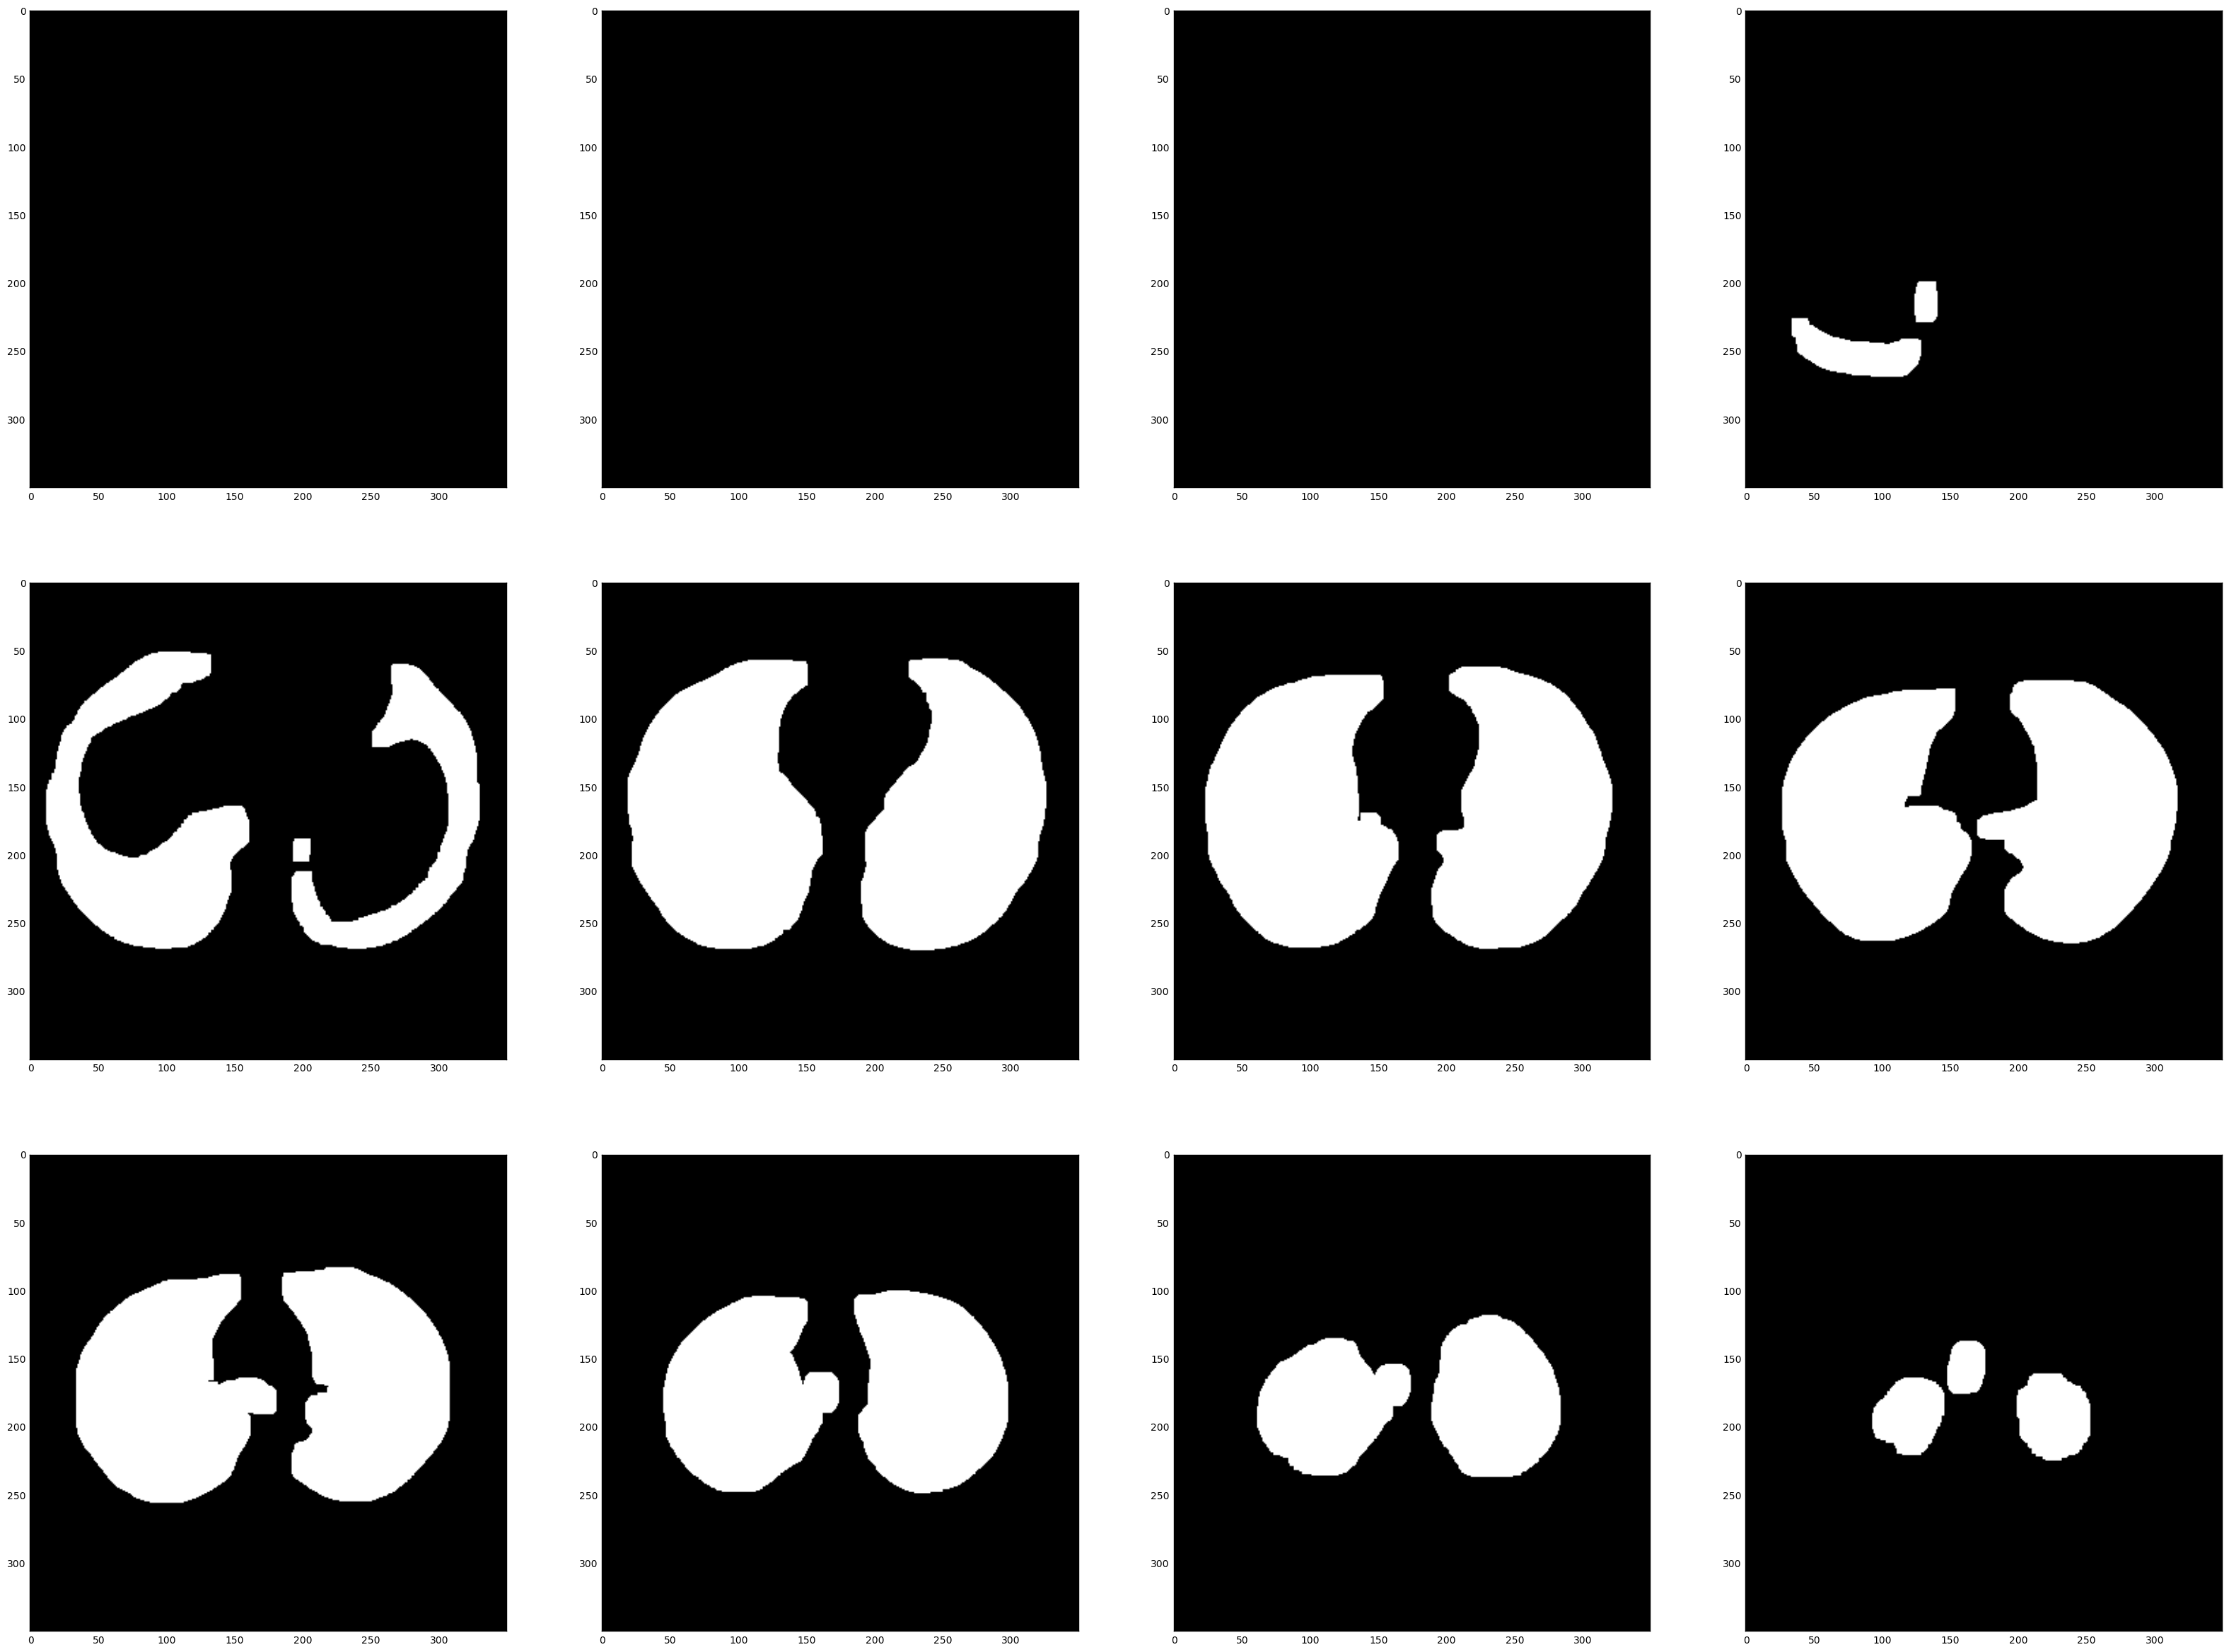

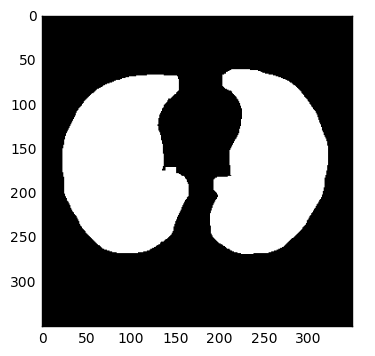

2017-02-18 21:32:40.862176 > [started] apply lung mask to image volume...
2017-02-18 21:32:41.179262 > [done]    apply lung mask to image volume (317.056 ms)
2017-02-18 21:32:41.179418 > [started] rotate image for optimal pose...
2017-02-18 21:32:47.154735 > [done]    rotate image for optimal pose (5975.276 ms)
2017-02-18 21:32:47.154896 > [started] resize image volume to 224x152x224...
ratio= 0.697247706422
2017-02-18 21:32:49.883281 > [done]    resize image volume to 224x152x224 (2728.348 ms)
2017-02-18 21:32:49.883439 > [started] translate to center...
2017-02-18 21:32:52.542544 > [done]    translate to center (2659.070 ms)
2017-02-18 21:32:52.542735 > [started] pixel normalization...
mean pixels= 0.61252478756
2017-02-18 21:32:52.624173 > [done]    pixel normalization (81.408 ms)
2017-02-18 21:32:52.624266 > [started] generate_slice 112...


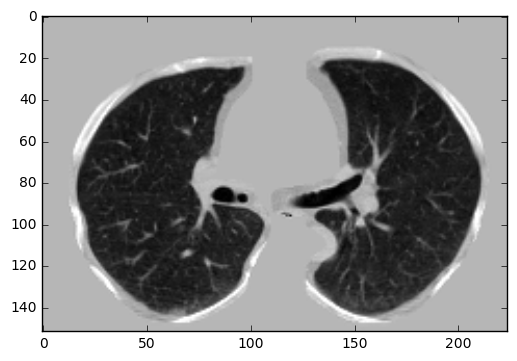

2017-02-18 21:32:52.947117 > [done]    generate_slice 112 (322.834 ms)
2017-02-18 21:32:52.947186 > [started] put patient image into dataset...
2017-02-18 21:32:52.988809 > [done]    put patient image into dataset (41.600 ms)
2017-02-18 21:32:52.997133 > [done]    >>> PATIENT PROCESSING 5a42f0a0d1e060531c20d04ed23efc02 (count=2; output_dir=../../output/step3/1/) (42504.747 ms)
2017-02-18 21:32:52.997188 > [started] >>> PATIENT PROCESSING 5c0d992d01e6383d5684b8ac5d7143b1 (count=3; output_dir=../../output/step3/1/)...
2017-02-18 21:32:52.997214 > [started] load_scan output/5c0d992d01e6383d5684b8ac5d7143b1...
2017-02-18 21:32:53.669996 > [done]    load_scan output/5c0d992d01e6383d5684b8ac5d7143b1 (672.765 ms)


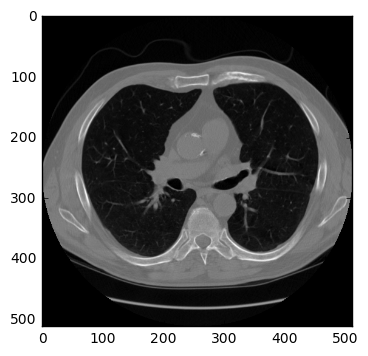

2017-02-18 21:32:54.108059 > [started] resample...
2017-02-18 21:33:11.823681 > [done]    resample (17715.587 ms)
2017-02-18 21:33:11.823989 > [started] segment_lung_mask...
1
2
bgs [0, 0, 0, 2]
lung_label 12
remove non lung structures
fill_lung_structures
2017-02-18 21:33:17.979172 > [done]    segment_lung_mask (6155.131 ms)


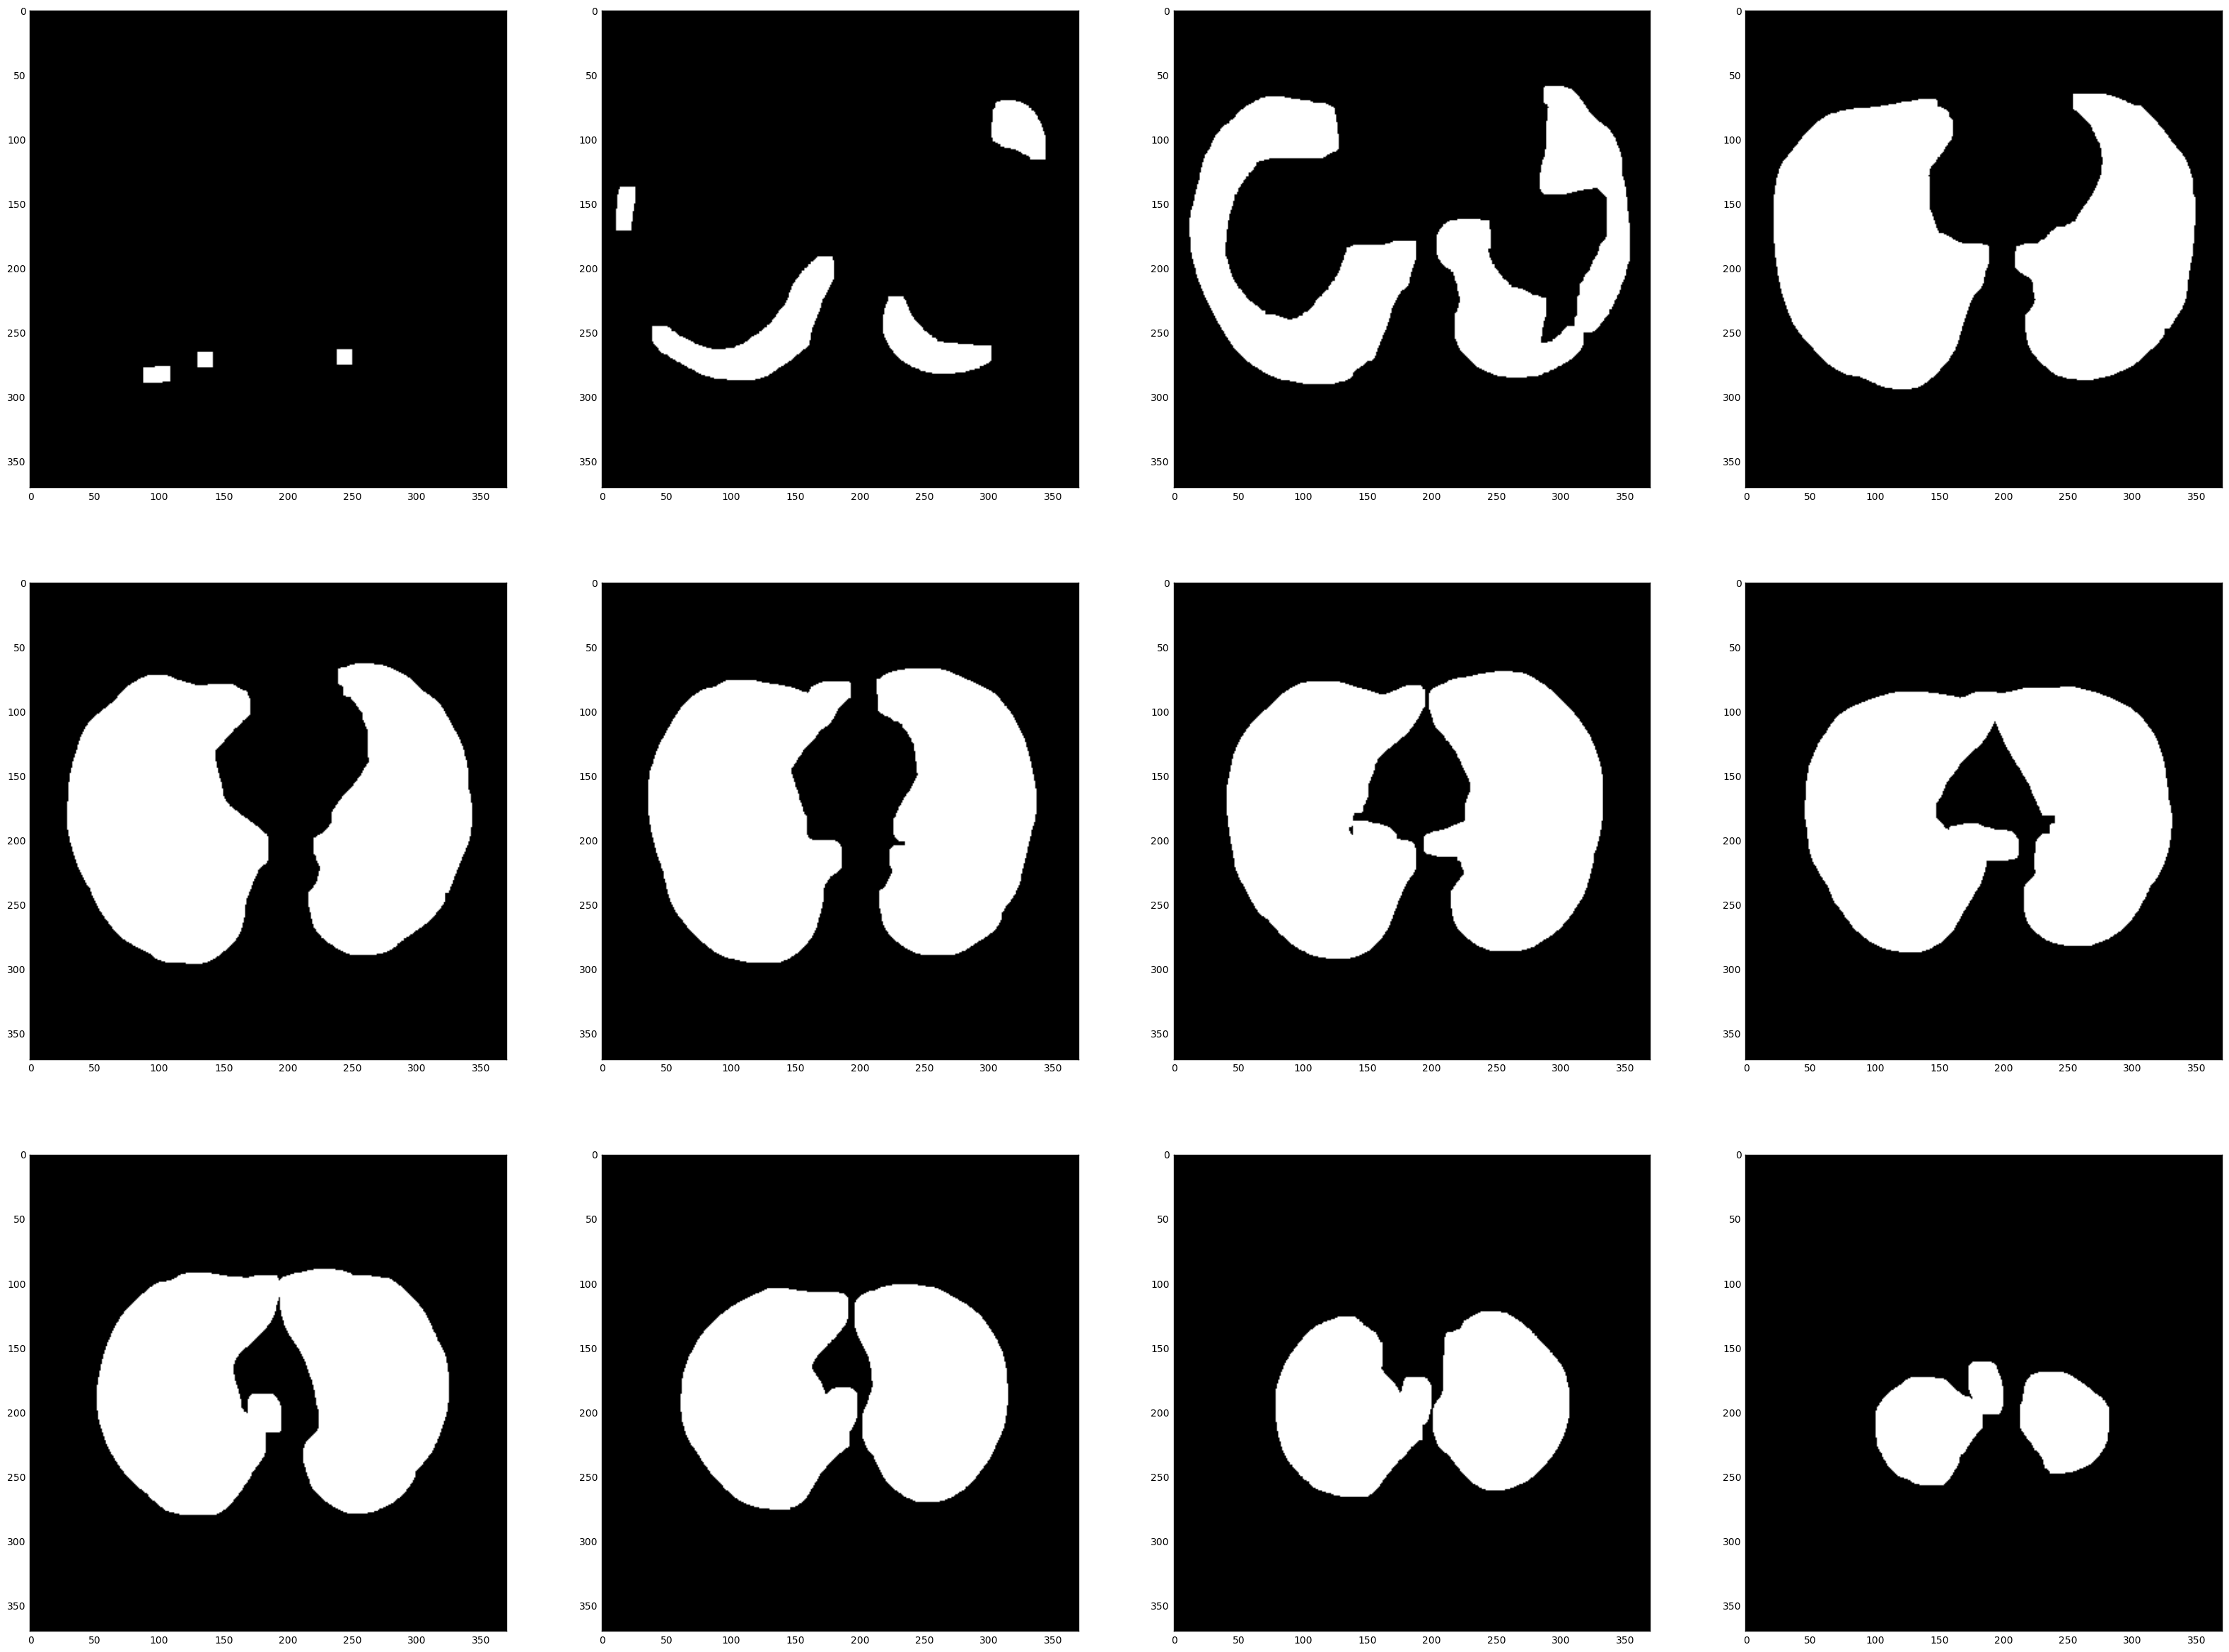

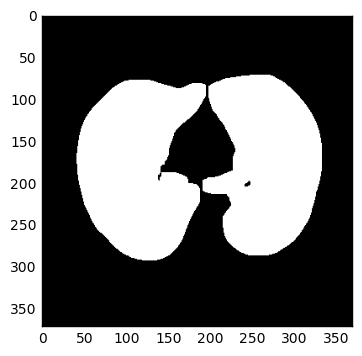

2017-02-18 21:33:23.218996 > [started] apply lung mask to image volume...
2017-02-18 21:33:23.486045 > [done]    apply lung mask to image volume (267.019 ms)
2017-02-18 21:33:23.486200 > [started] rotate image for optimal pose...
2017-02-18 21:33:29.129035 > [done]    rotate image for optimal pose (5642.801 ms)
2017-02-18 21:33:29.129189 > [started] resize image volume to 224x152x224...
ratio= 0.64406779661
2017-02-18 21:33:31.885600 > [done]    resize image volume to 224x152x224 (2756.368 ms)
2017-02-18 21:33:31.885794 > [started] translate to center...
2017-02-18 21:33:34.456578 > [done]    translate to center (2570.757 ms)
2017-02-18 21:33:34.456736 > [started] pixel normalization...
mean pixels= 0.586263265336
2017-02-18 21:33:34.526854 > [done]    pixel normalization (70.087 ms)
2017-02-18 21:33:34.526941 > [started] generate_slice 112...


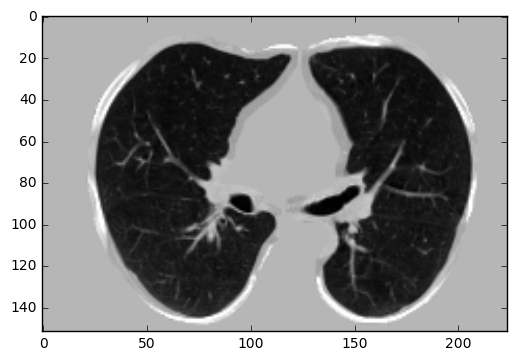

2017-02-18 21:33:34.915635 > [done]    generate_slice 112 (388.680 ms)
2017-02-18 21:33:34.915687 > [started] put patient image into dataset...
2017-02-18 21:33:34.960254 > [done]    put patient image into dataset (44.544 ms)
2017-02-18 21:33:34.968497 > [done]    >>> PATIENT PROCESSING 5c0d992d01e6383d5684b8ac5d7143b1 (count=3; output_dir=../../output/step3/1/) (41971.290 ms)
2017-02-18 21:33:34.968565 > [started] >>> PATIENT PROCESSING 66fb40934f0be4b301fe27db7fb62299 (count=4; output_dir=../../output/step3/1/)...
2017-02-18 21:33:34.968594 > [started] load_scan output/66fb40934f0be4b301fe27db7fb62299...
2017-02-18 21:33:35.947967 > [done]    load_scan output/66fb40934f0be4b301fe27db7fb62299 (979.345 ms)


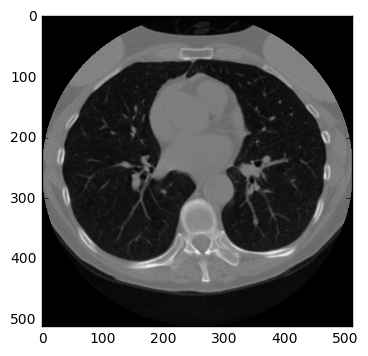

2017-02-18 21:33:36.319444 > [started] resample...
2017-02-18 21:33:47.372455 > [done]    resample (11052.977 ms)
2017-02-18 21:33:47.372758 > [started] segment_lung_mask...
1
2
bgs [0, 0, 0, 2]
lung_label 15
remove non lung structures
fill_lung_structures
2017-02-18 21:33:50.231241 > [done]    segment_lung_mask (2858.443 ms)


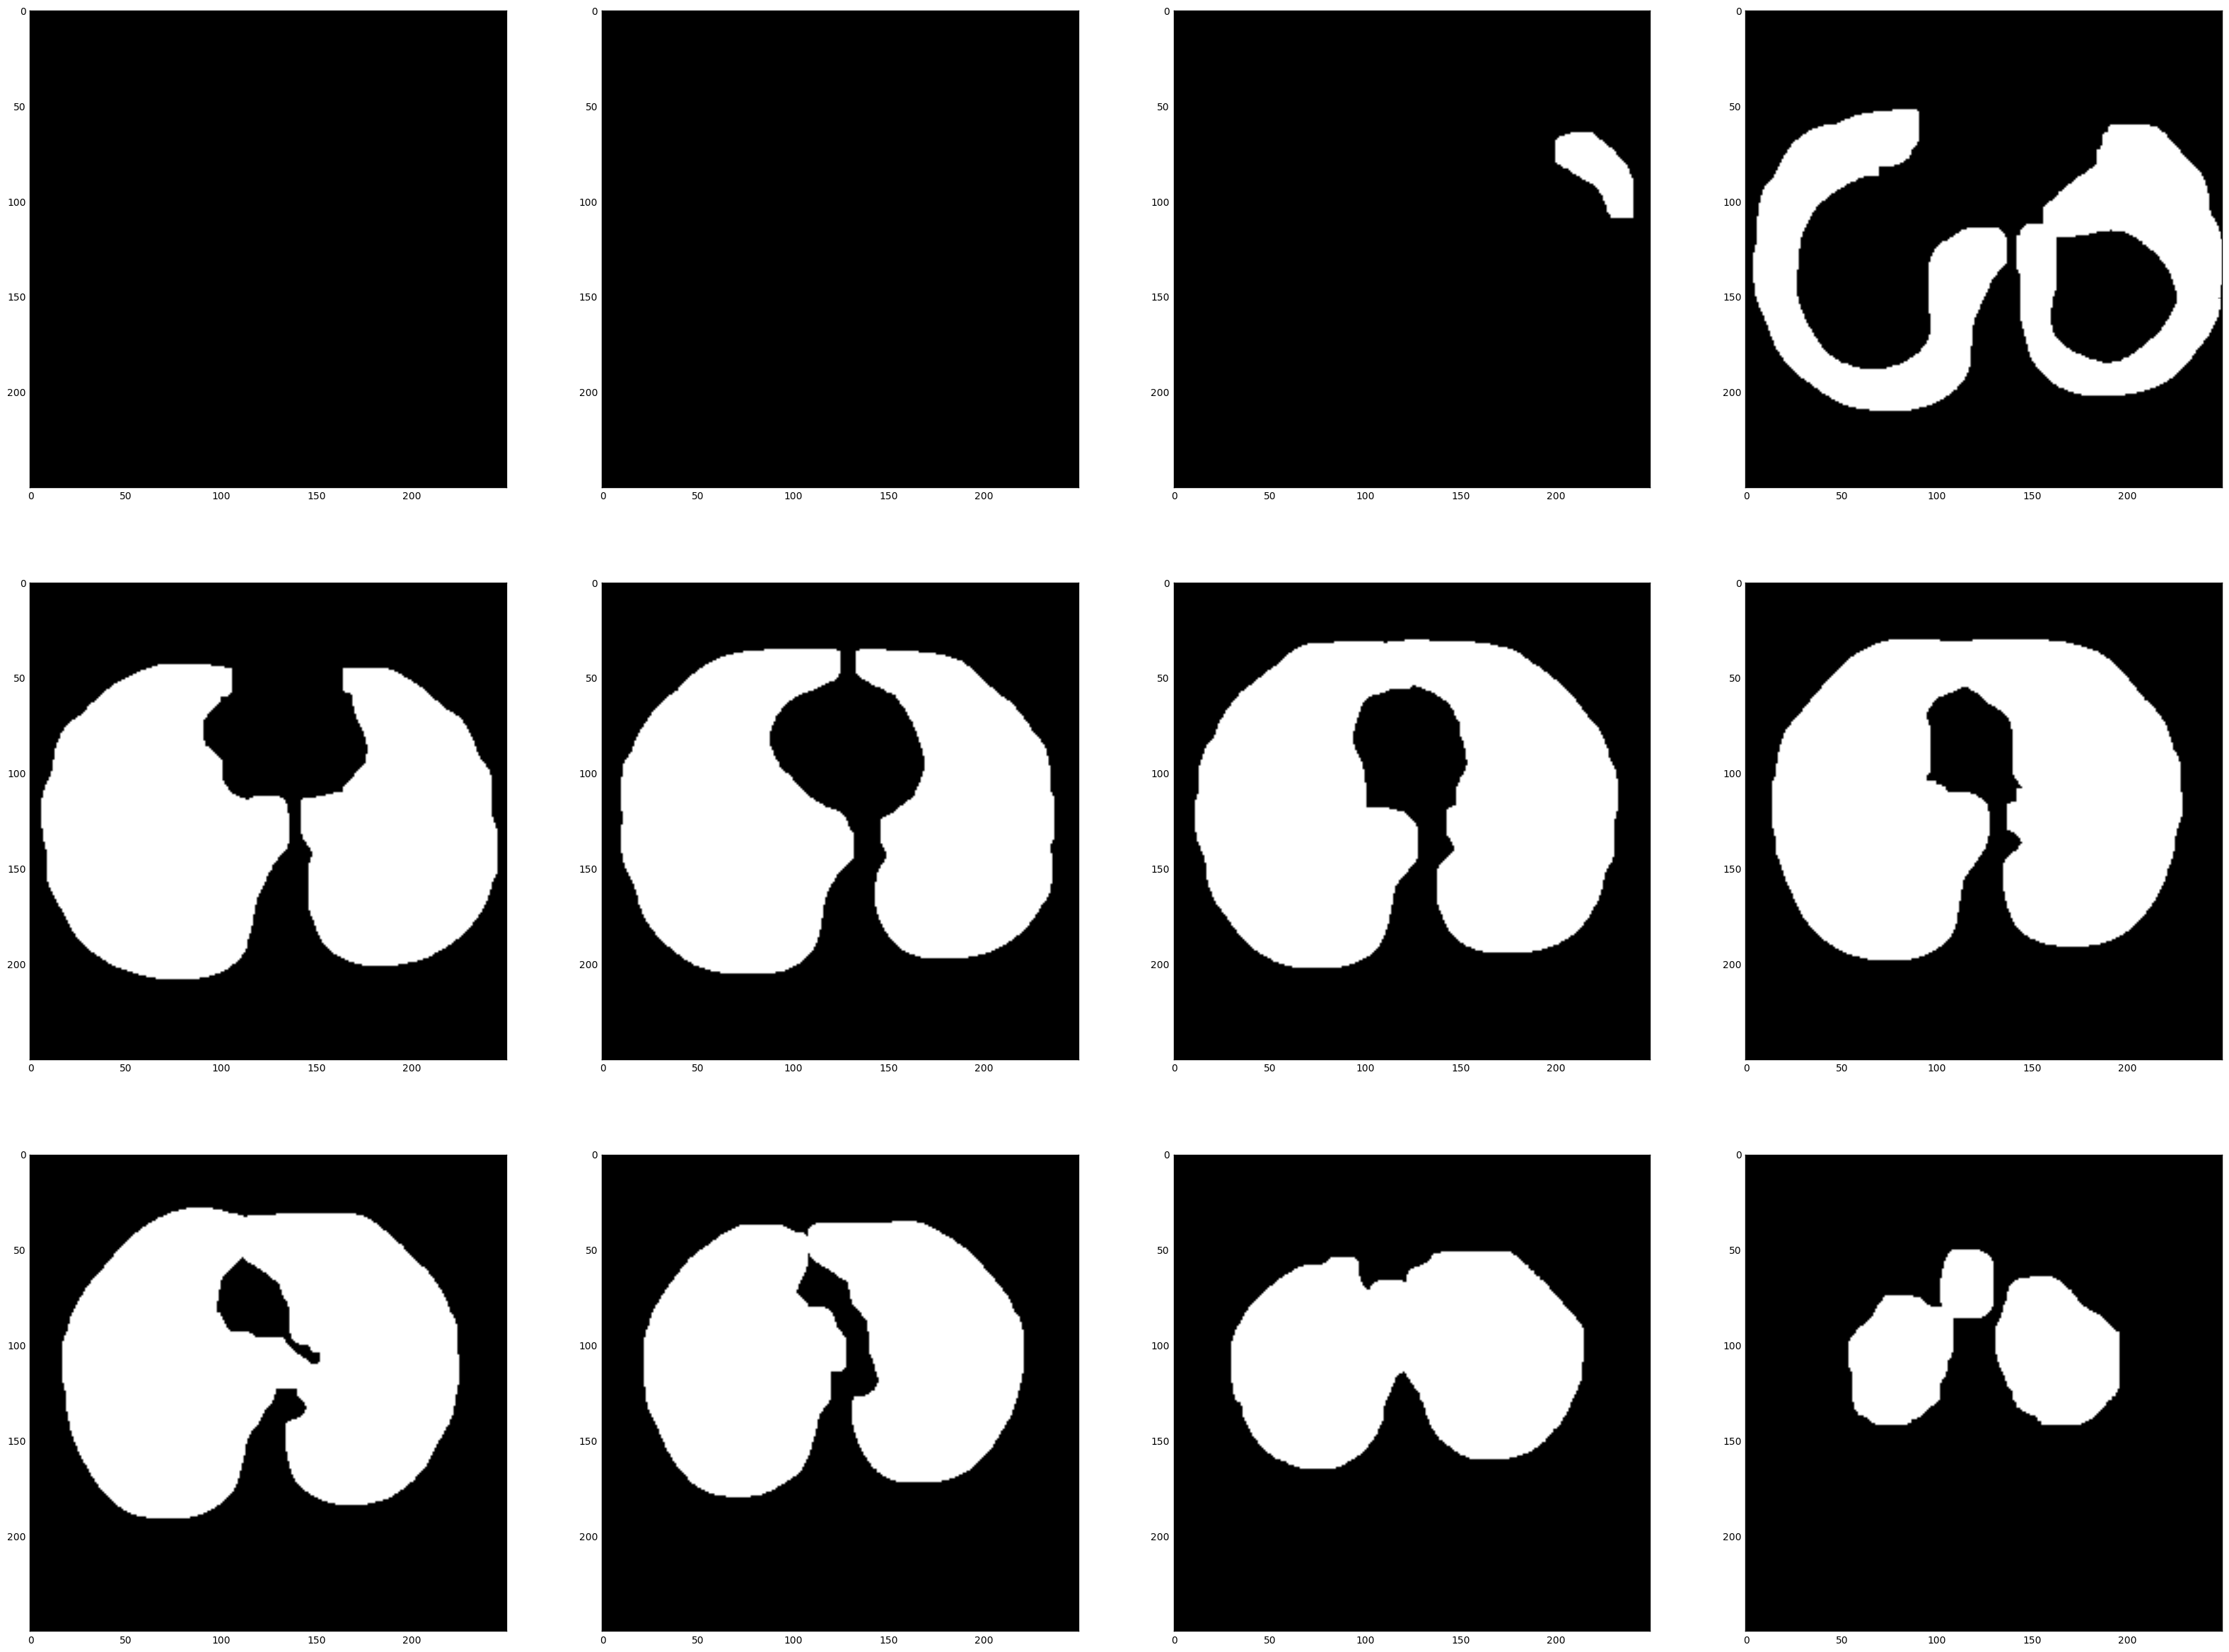

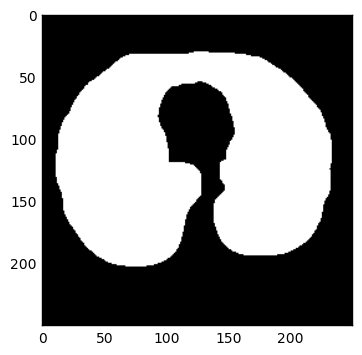

2017-02-18 21:33:55.089931 > [started] apply lung mask to image volume...
2017-02-18 21:33:55.216159 > [done]    apply lung mask to image volume (126.199 ms)
2017-02-18 21:33:55.216243 > [started] rotate image for optimal pose...
Strange rotation detected. returning 0 degrees
2017-02-18 21:33:58.053769 > [done]    rotate image for optimal pose (2837.494 ms)
2017-02-18 21:33:58.053925 > [started] resize image volume to 224x152x224...
ratio= 0.835164835165
2017-02-18 21:34:00.848963 > [done]    resize image volume to 224x152x224 (2795.007 ms)
2017-02-18 21:34:00.849119 > [started] translate to center...
2017-02-18 21:34:03.710094 > [done]    translate to center (2860.919 ms)
2017-02-18 21:34:03.710322 > [started] pixel normalization...
mean pixels= 0.557171318425
2017-02-18 21:34:03.819484 > [done]    pixel normalization (109.096 ms)
2017-02-18 21:34:03.819593 > [started] generate_slice 112...


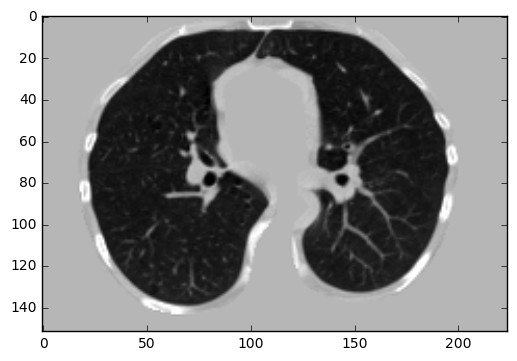

2017-02-18 21:34:04.128607 > [done]    generate_slice 112 (309.001 ms)
2017-02-18 21:34:04.128662 > [started] put patient image into dataset...
2017-02-18 21:34:04.242970 > [done]    put patient image into dataset (114.283 ms)
2017-02-18 21:34:04.254516 > [done]    >>> PATIENT PROCESSING 66fb40934f0be4b301fe27db7fb62299 (count=4; output_dir=../../output/step3/1/) (29285.933 ms)
2017-02-18 21:34:04.254580 > [started] >>> PATIENT PROCESSING 7bfba4540956c0b2c5b78b3623a4855d (count=5; output_dir=../../output/step3/1/)...
2017-02-18 21:34:04.254607 > [started] load_scan output/7bfba4540956c0b2c5b78b3623a4855d...
2017-02-18 21:34:07.509229 > [done]    load_scan output/7bfba4540956c0b2c5b78b3623a4855d (3254.596 ms)


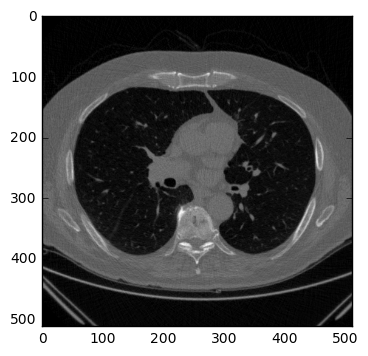

2017-02-18 21:34:08.709669 > [started] resample...
2017-02-18 21:34:37.636384 > [done]    resample (28926.675 ms)
2017-02-18 21:34:37.648611 > [started] segment_lung_mask...
1
2
bgs [0, 0, 0, 2]
lung_label 34
remove non lung structures
fill_lung_structures
2017-02-18 21:34:44.249804 > [done]    segment_lung_mask (6601.166 ms)


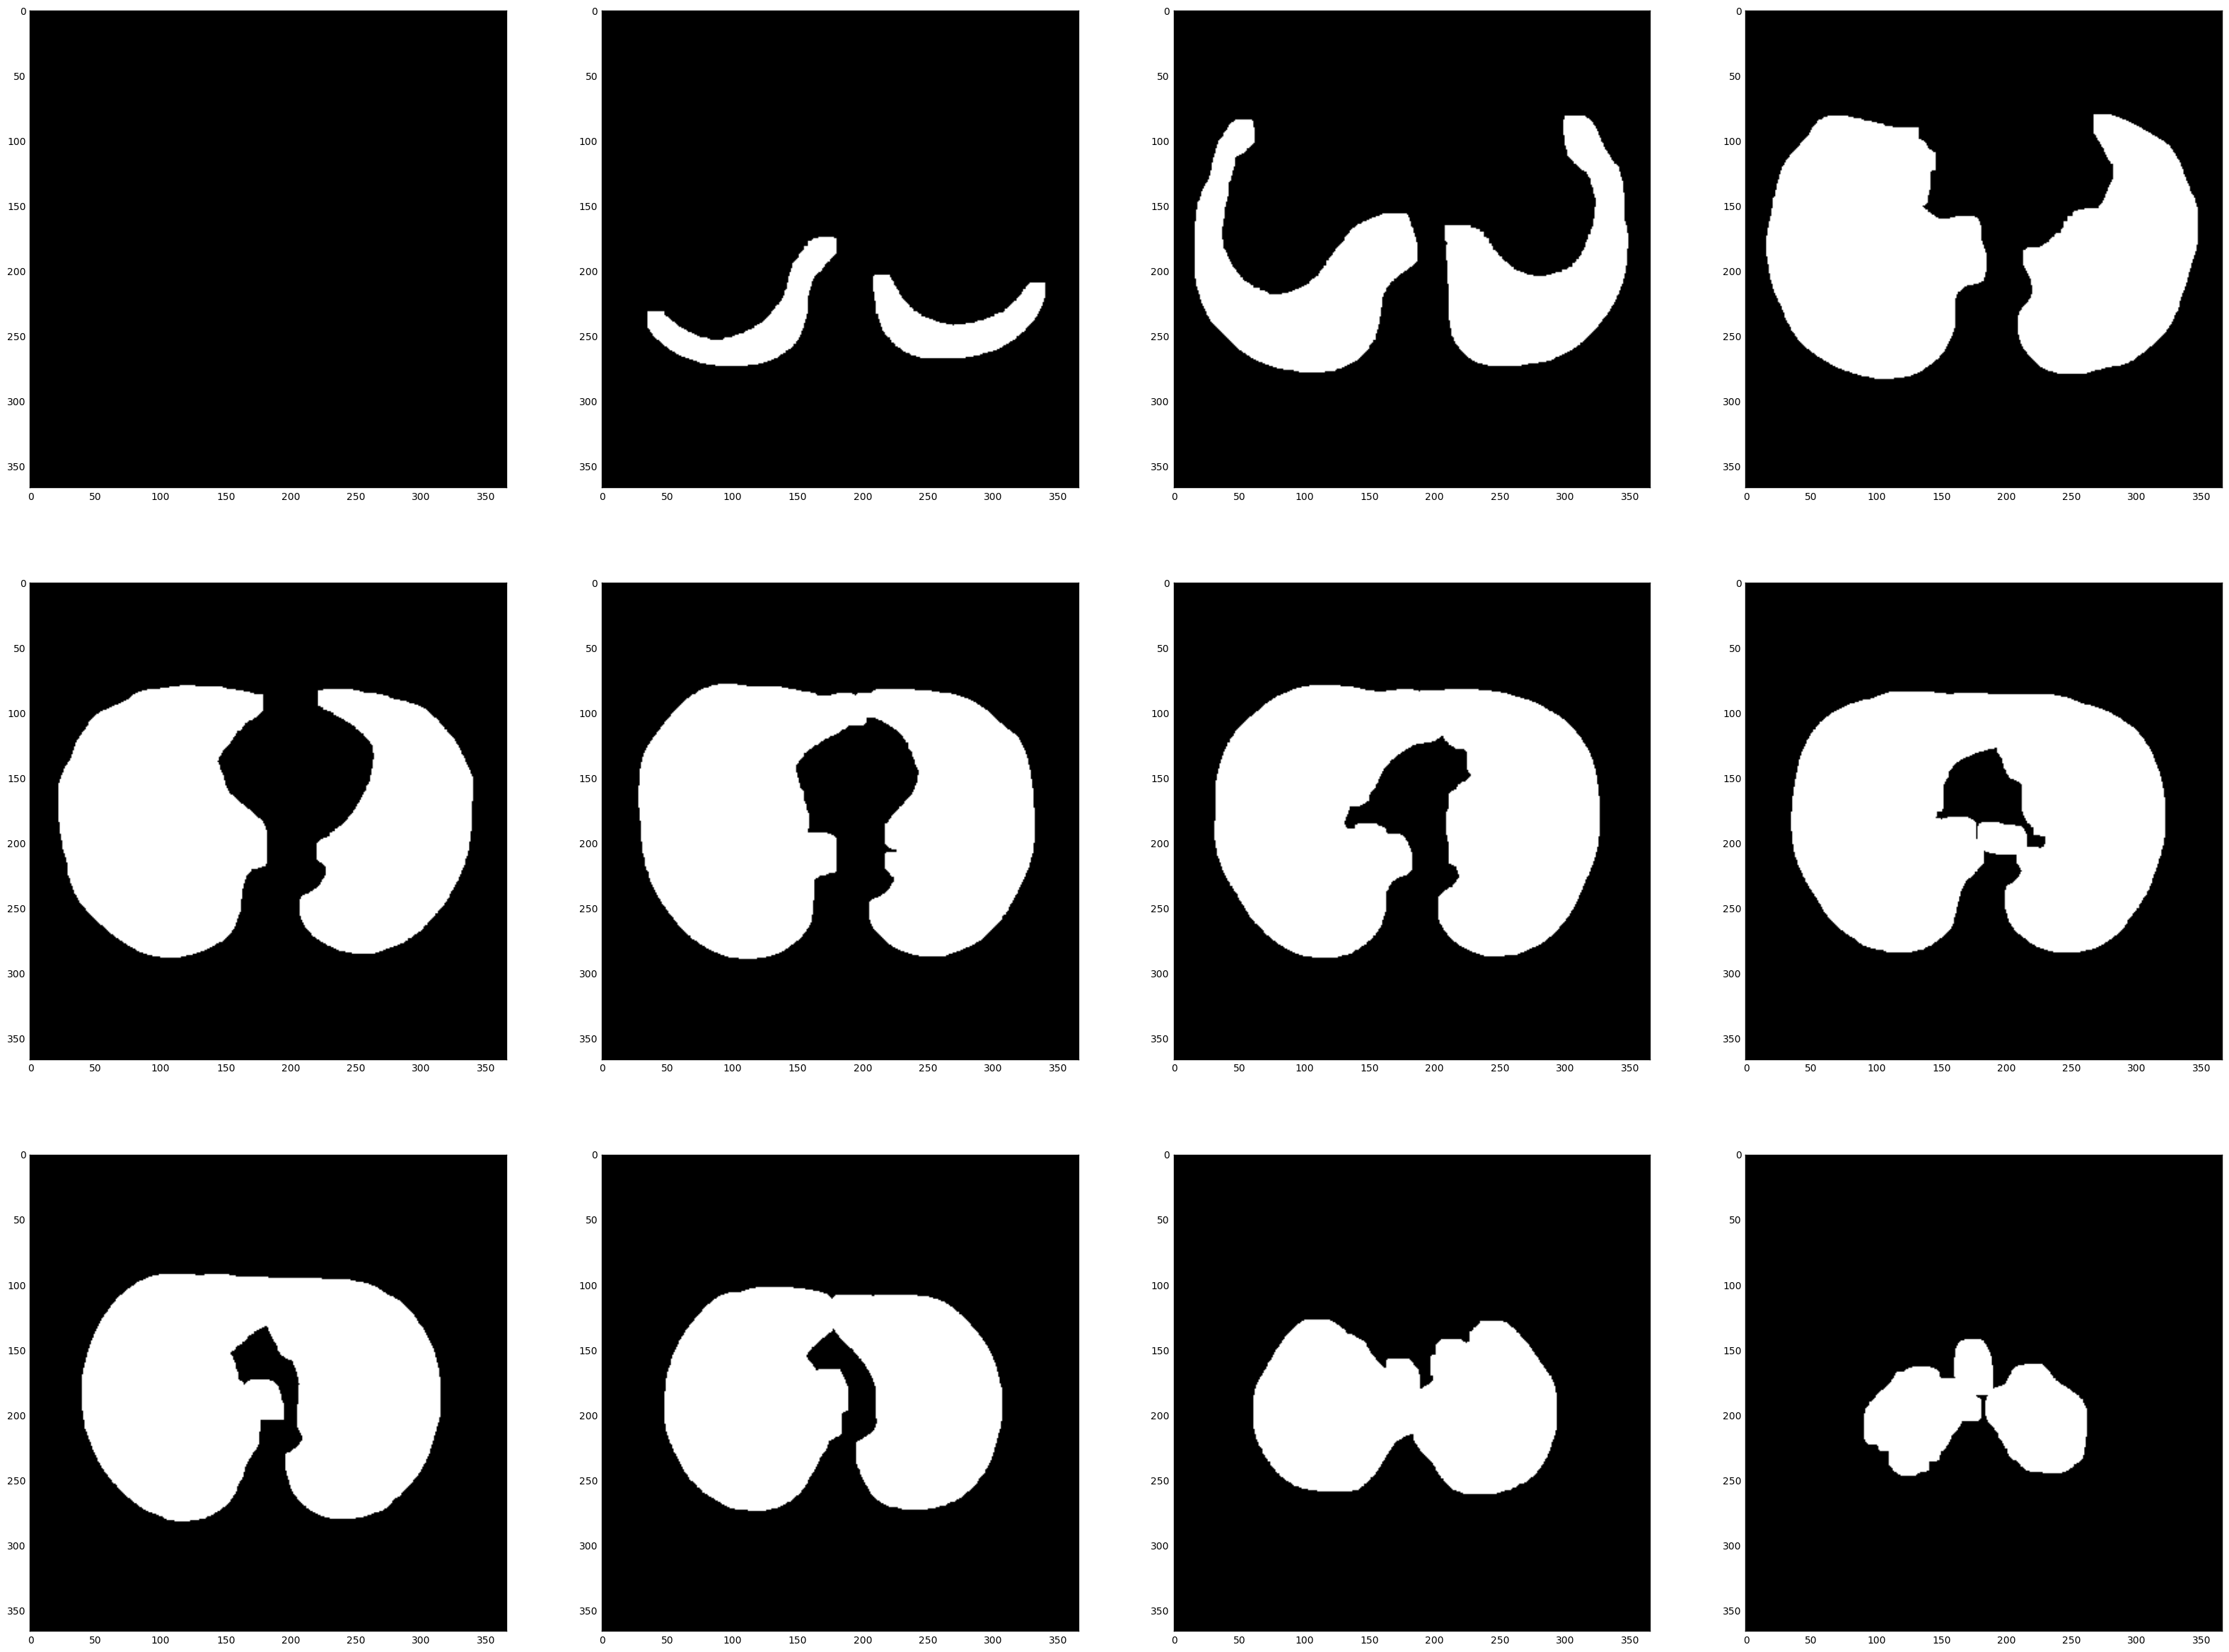

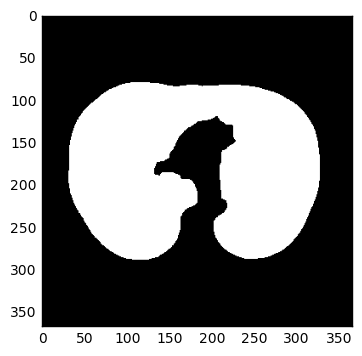

2017-02-18 21:34:49.584761 > [started] apply lung mask to image volume...
2017-02-18 21:34:49.910326 > [done]    apply lung mask to image volume (325.533 ms)
2017-02-18 21:34:49.910482 > [started] rotate image for optimal pose...
2017-02-18 21:34:56.851738 > [done]    rotate image for optimal pose (6941.216 ms)
2017-02-18 21:34:56.851905 > [started] resize image volume to 224x152x224...
ratio= 0.672672672673
2017-02-18 21:35:00.180329 > [done]    resize image volume to 224x152x224 (3328.383 ms)
2017-02-18 21:35:00.180492 > [started] translate to center...
2017-02-18 21:35:03.138707 > [done]    translate to center (2958.180 ms)
2017-02-18 21:35:03.138860 > [started] pixel normalization...
mean pixels= 0.542308919408
2017-02-18 21:35:03.242782 > [done]    pixel normalization (103.881 ms)
2017-02-18 21:35:03.242896 > [started] generate_slice 112...


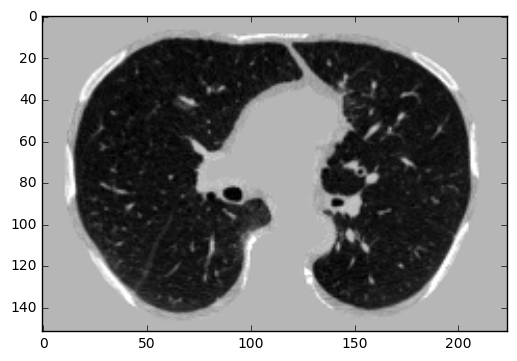

2017-02-18 21:35:03.581039 > [done]    generate_slice 112 (338.129 ms)
2017-02-18 21:35:03.581101 > [started] put patient image into dataset...
2017-02-18 21:35:03.710716 > [done]    put patient image into dataset (129.585 ms)
2017-02-18 21:35:03.732989 > [done]    >>> PATIENT PROCESSING 7bfba4540956c0b2c5b78b3623a4855d (count=5; output_dir=../../output/step3/1/) (59478.391 ms)
2017-02-18 21:35:03.733055 > [started] >>> PATIENT PROCESSING 7c02c641324c598cd935b588189c87db (count=6; output_dir=../../output/step3/1/)...
2017-02-18 21:35:03.733083 > [started] load_scan output/7c02c641324c598cd935b588189c87db...
2017-02-18 21:35:04.740909 > [done]    load_scan output/7c02c641324c598cd935b588189c87db (1007.807 ms)


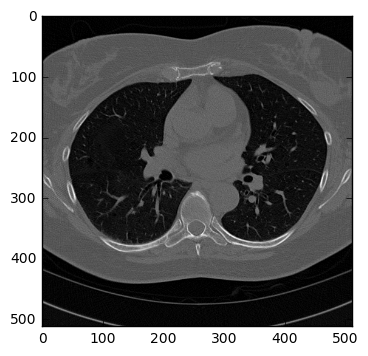

2017-02-18 21:35:05.130197 > [started] resample...
2017-02-18 21:35:17.304171 > [done]    resample (12173.944 ms)
2017-02-18 21:35:17.304337 > [started] segment_lung_mask...
1
2
bgs [0, 0, 0, 2]
lung_label 16
remove non lung structures
fill_lung_structures
2017-02-18 21:35:20.790379 > [done]    segment_lung_mask (3486.011 ms)


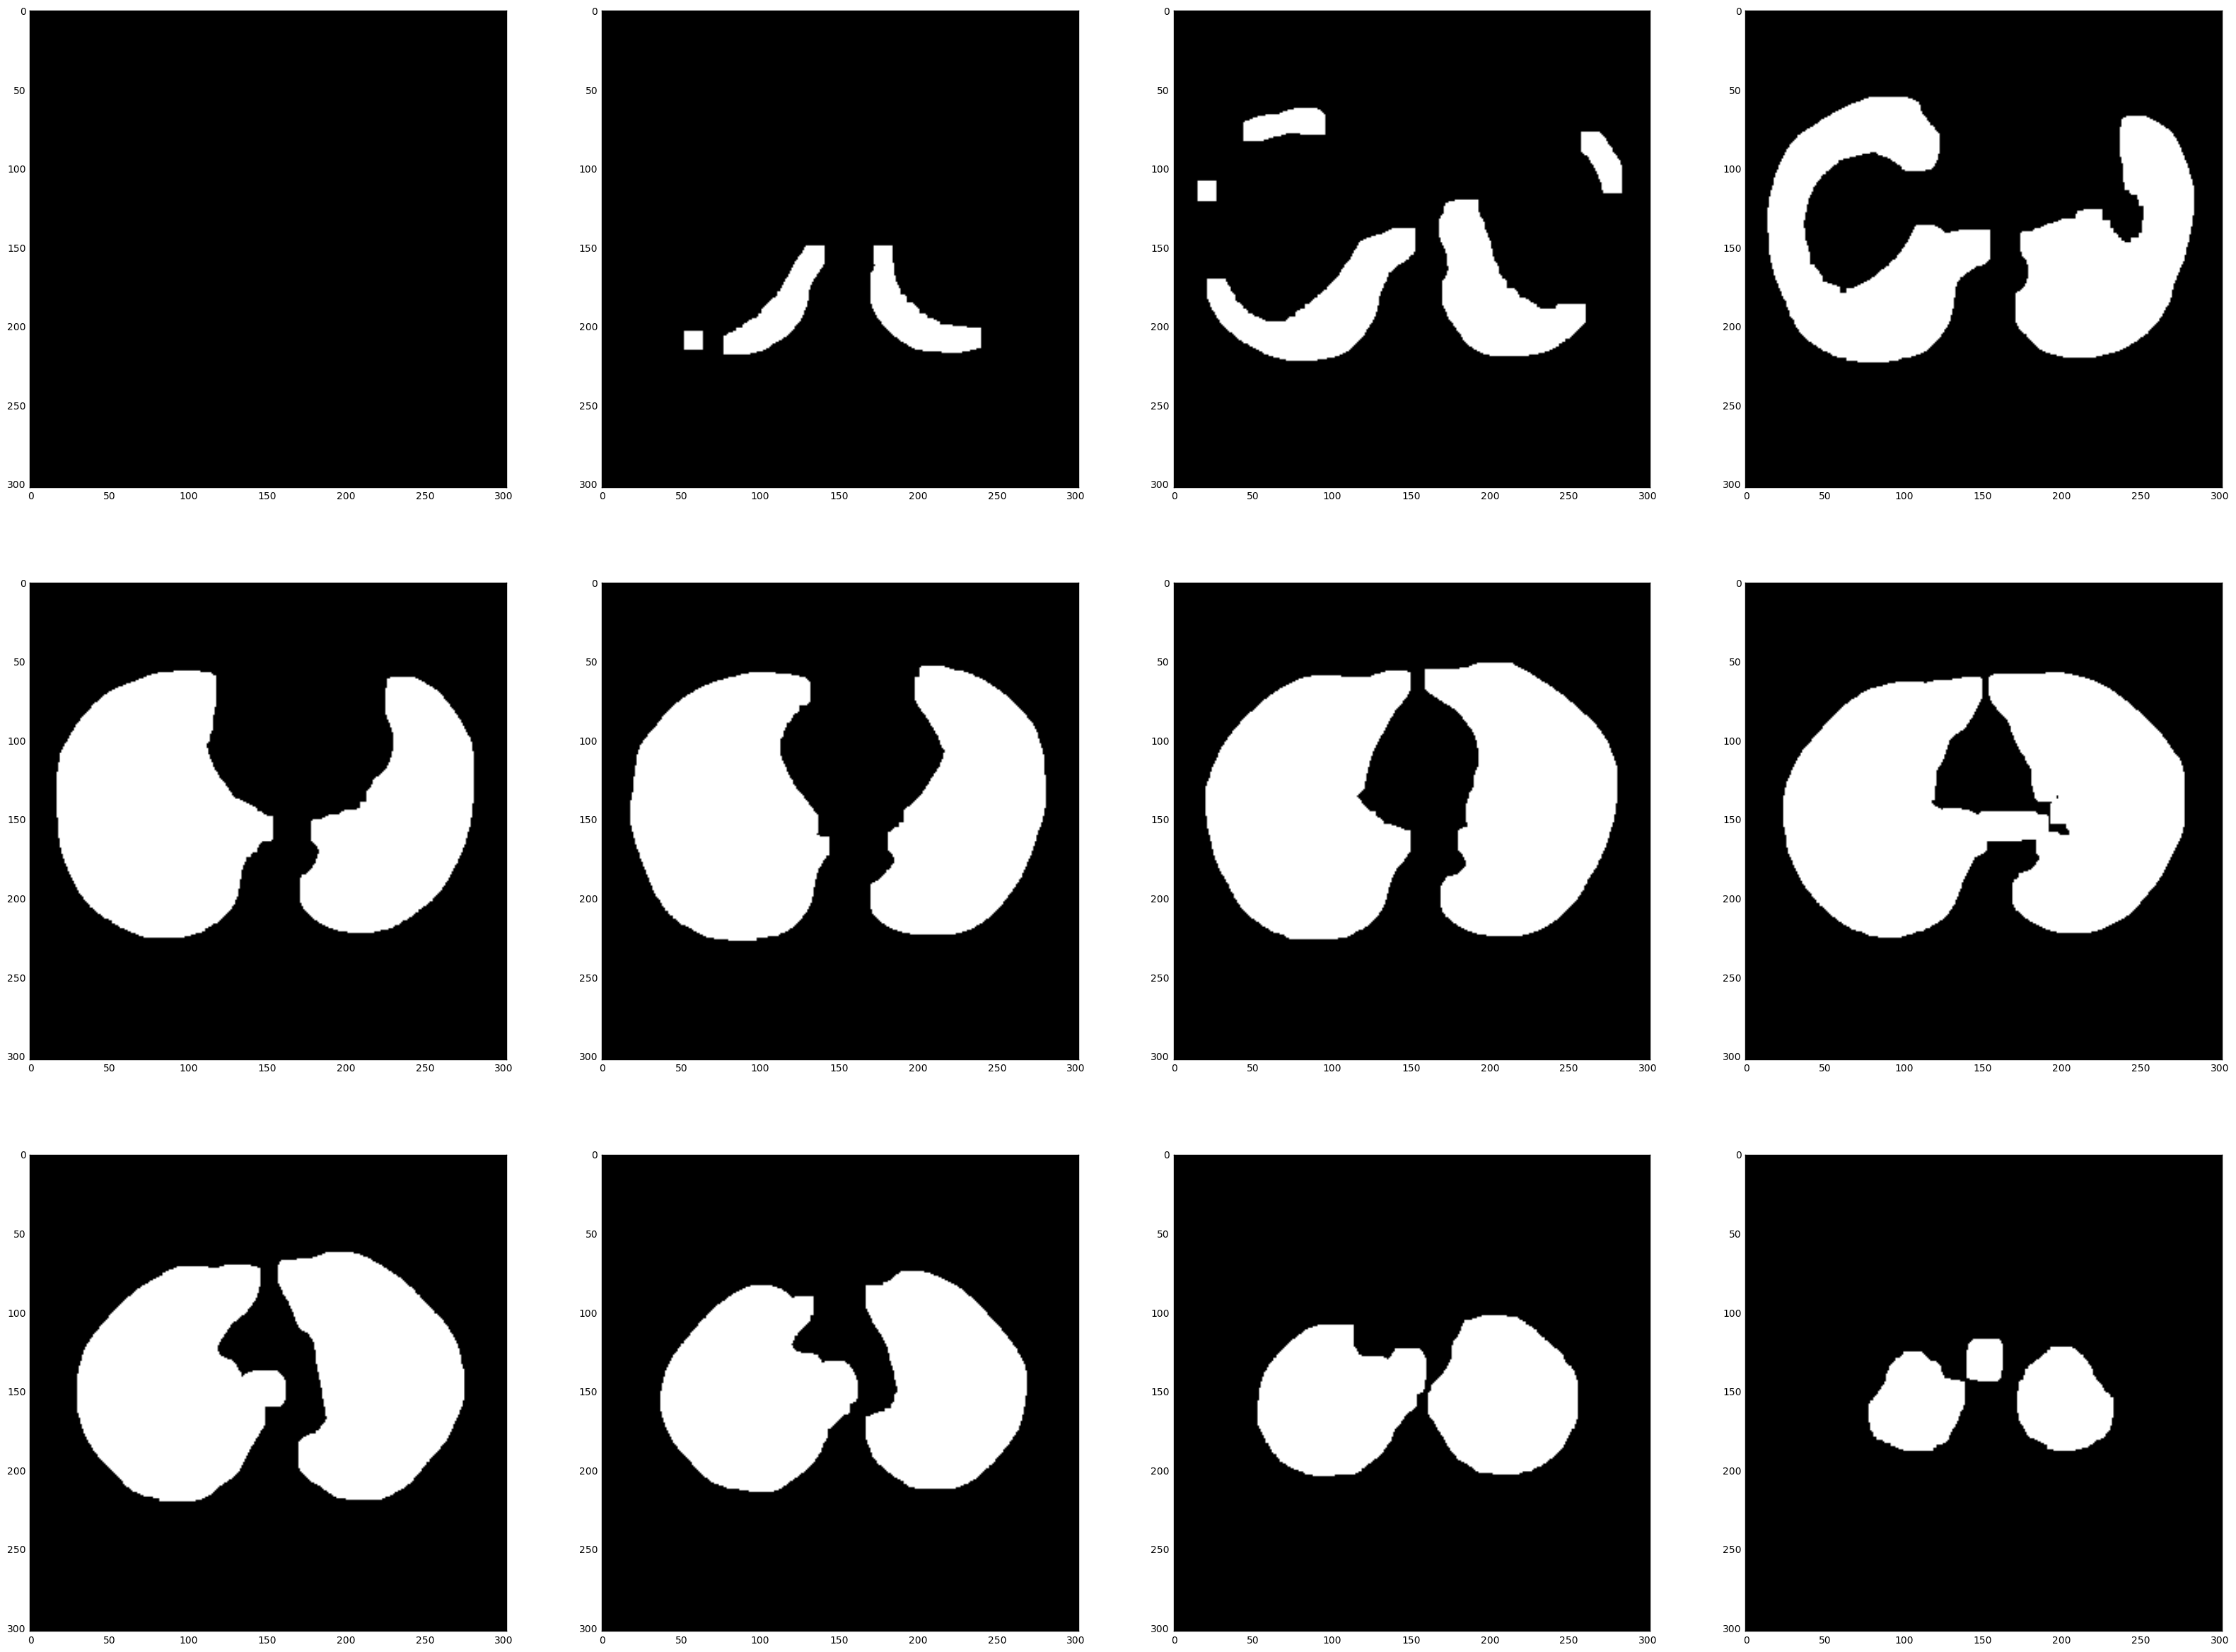

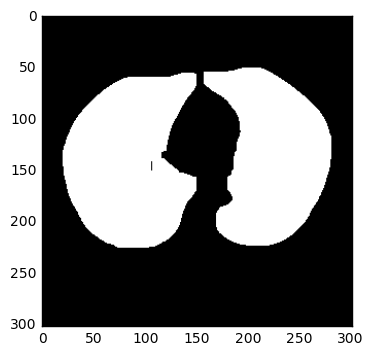

2017-02-18 21:35:25.907379 > [started] apply lung mask to image volume...
2017-02-18 21:35:26.051080 > [done]    apply lung mask to image volume (143.678 ms)
2017-02-18 21:35:26.051159 > [started] rotate image for optimal pose...
2017-02-18 21:35:29.868844 > [done]    rotate image for optimal pose (3817.657 ms)
2017-02-18 21:35:29.868991 > [started] resize image volume to 224x152x224...
ratio= 0.832713754647
2017-02-18 21:35:33.080052 > [done]    resize image volume to 224x152x224 (3211.017 ms)
2017-02-18 21:35:33.080266 > [started] translate to center...
2017-02-18 21:35:35.831485 > [done]    translate to center (2751.189 ms)
2017-02-18 21:35:35.831648 > [started] pixel normalization...
mean pixels= 0.580309470251
2017-02-18 21:35:35.882711 > [done]    pixel normalization (51.034 ms)
2017-02-18 21:35:35.882798 > [started] generate_slice 112...


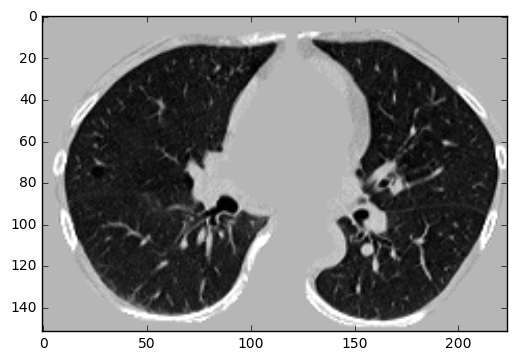

2017-02-18 21:35:36.191728 > [done]    generate_slice 112 (308.909 ms)
2017-02-18 21:35:36.191810 > [started] put patient image into dataset...
2017-02-18 21:35:36.277307 > [done]    put patient image into dataset (85.470 ms)
2017-02-18 21:35:36.285481 > [done]    >>> PATIENT PROCESSING 7c02c641324c598cd935b588189c87db (count=6; output_dir=../../output/step3/1/) (32552.397 ms)
2017-02-18 21:35:36.285549 > [started] >>> PATIENT PROCESSING 01f1140c8e951e2a921b61c9a7e782c2 (count=7; output_dir=../../output/step3/1/)...
2017-02-18 21:35:36.285577 > [started] load_scan output/01f1140c8e951e2a921b61c9a7e782c2...
2017-02-18 21:35:37.539058 > [done]    load_scan output/01f1140c8e951e2a921b61c9a7e782c2 (1253.463 ms)


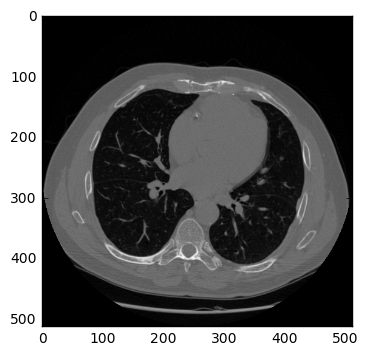

2017-02-18 21:35:37.993633 > [started] resample...
2017-02-18 21:35:59.263787 > [done]    resample (21270.118 ms)
2017-02-18 21:35:59.264122 > [started] segment_lung_mask...
1
2
bgs [0, 0, 0, 2]
lung_label 108
remove non lung structures
fill_lung_structures
2017-02-18 21:36:05.192180 > [done]    segment_lung_mask (5928.032 ms)


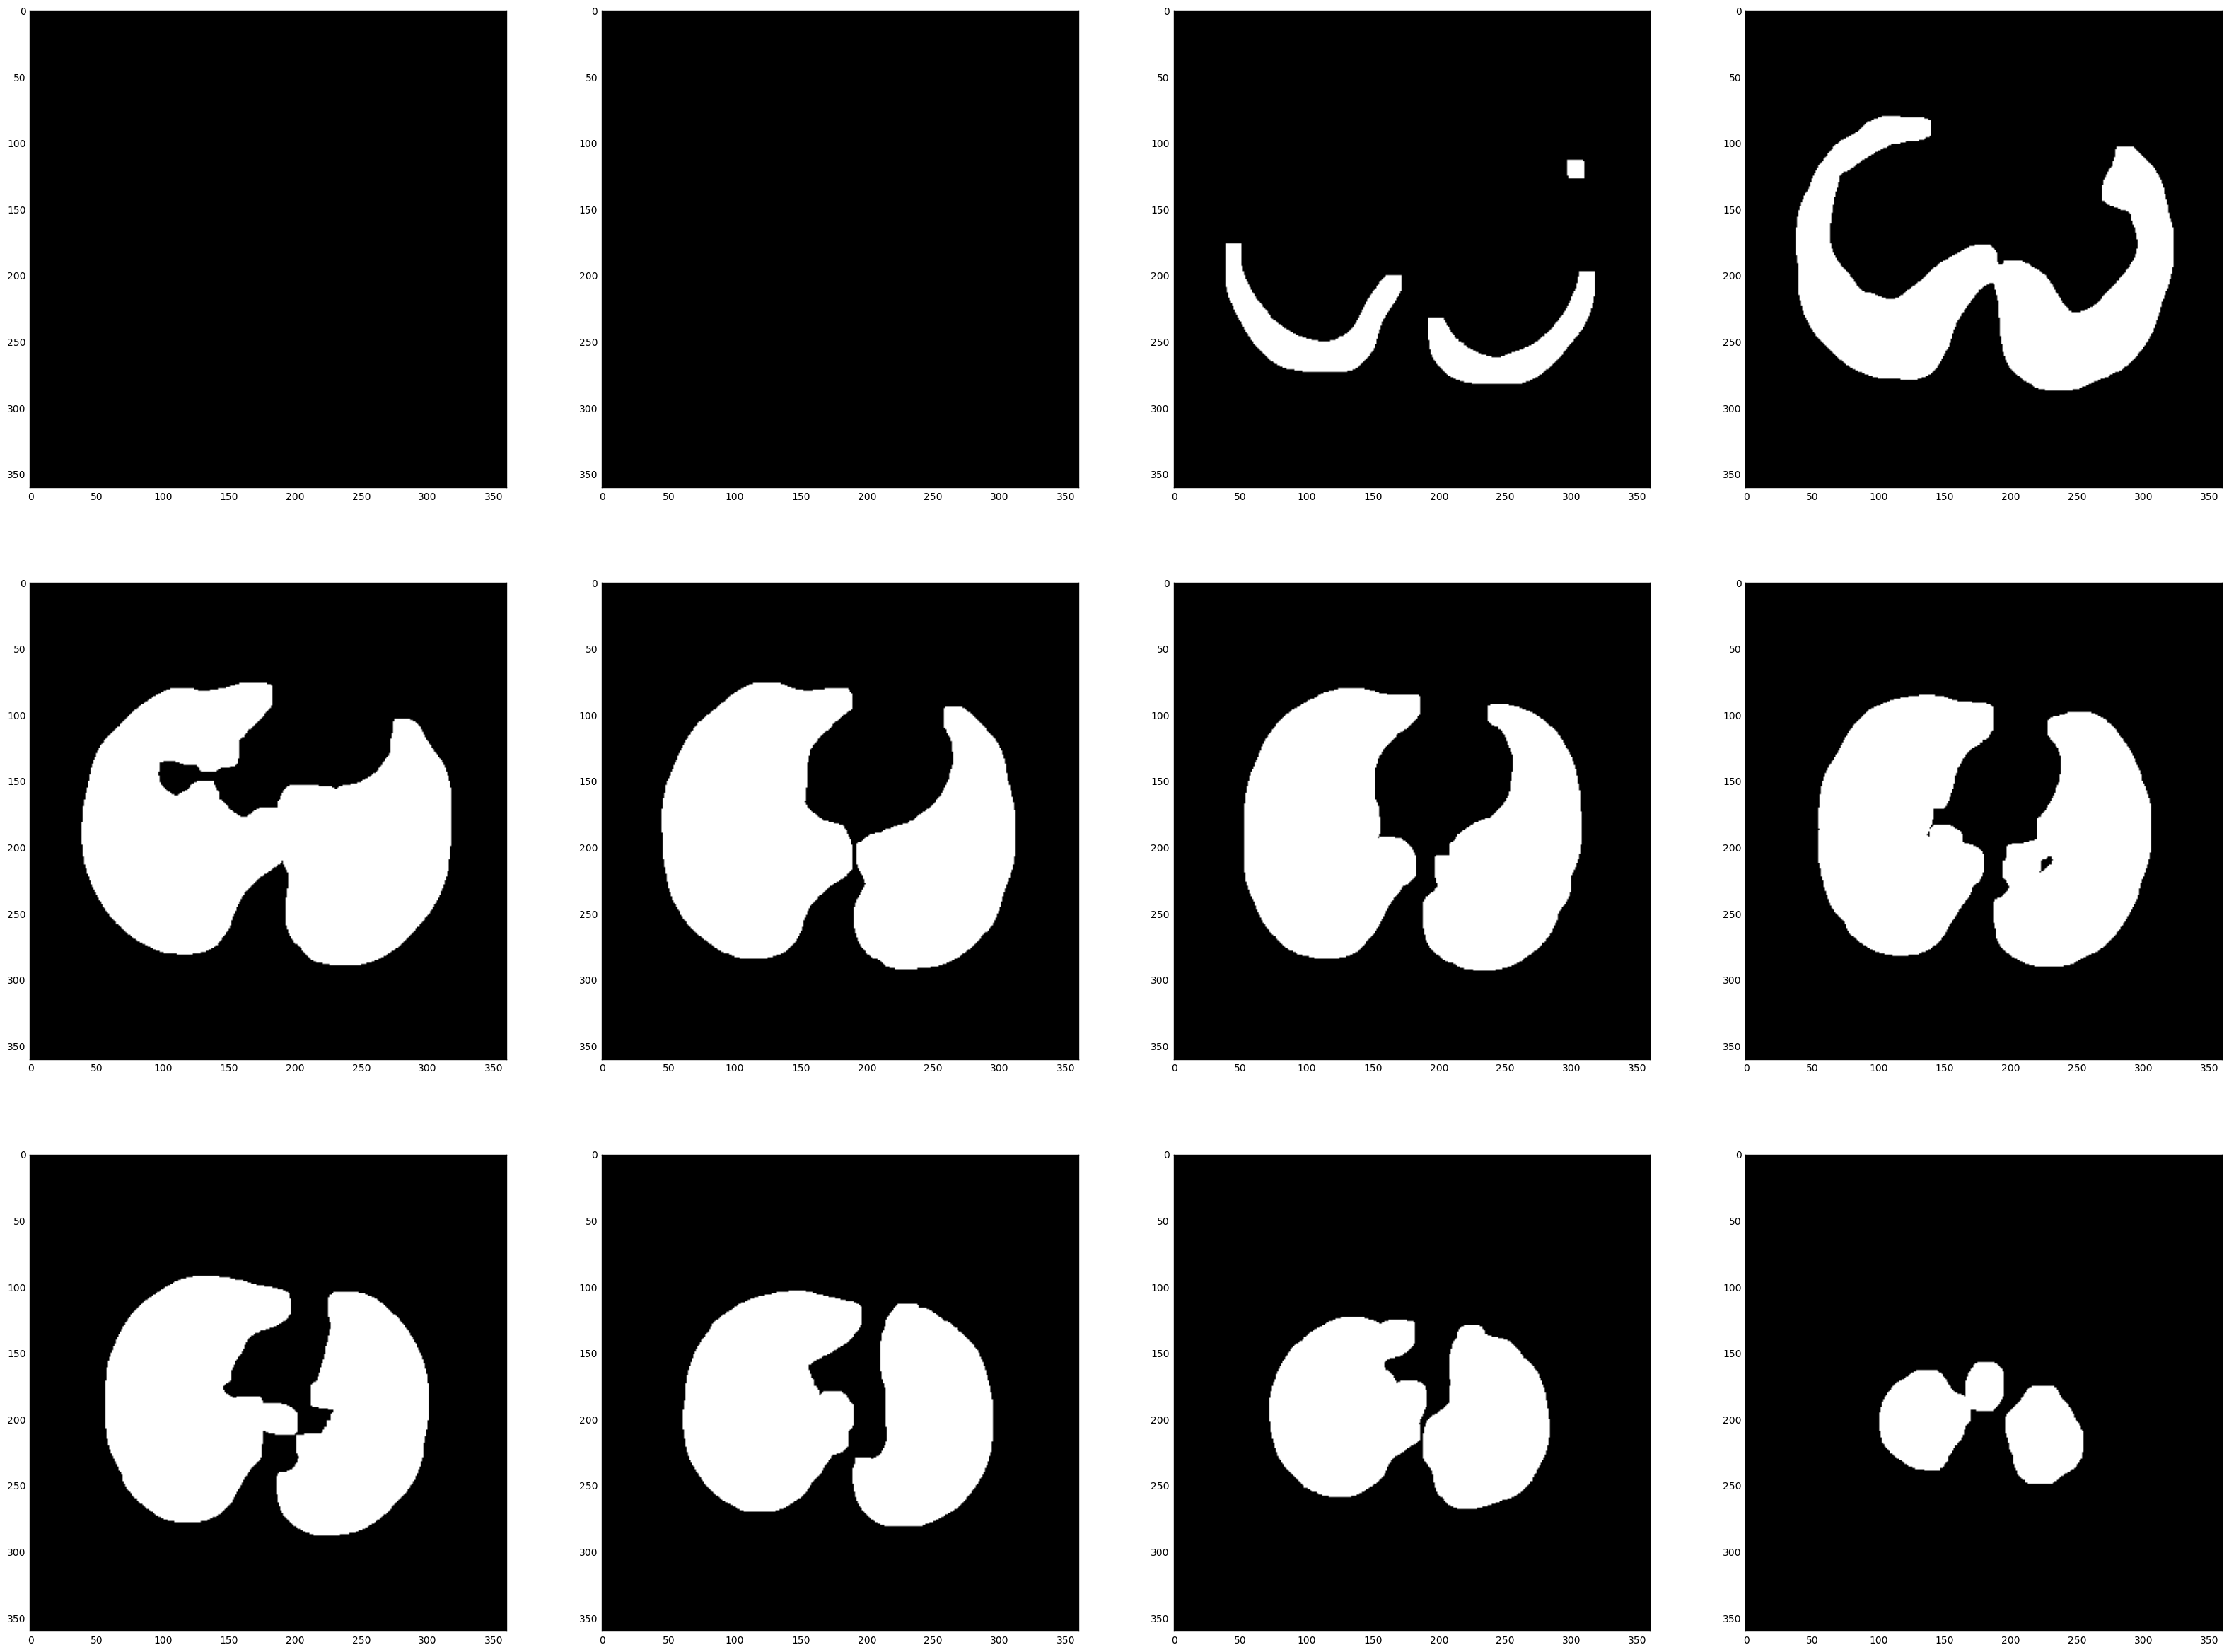

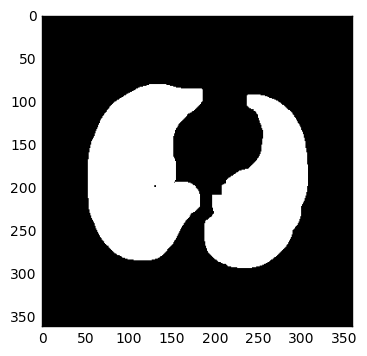

2017-02-18 21:36:10.338220 > [started] apply lung mask to image volume...
2017-02-18 21:36:10.596973 > [done]    apply lung mask to image volume (258.725 ms)
2017-02-18 21:36:10.597128 > [started] rotate image for optimal pose...
2017-02-18 21:36:16.297339 > [done]    rotate image for optimal pose (5700.176 ms)
2017-02-18 21:36:16.297495 > [started] resize image volume to 224x152x224...
ratio= 0.703703703704
2017-02-18 21:36:19.036203 > [done]    resize image volume to 224x152x224 (2738.671 ms)
2017-02-18 21:36:19.036376 > [started] translate to center...
2017-02-18 21:36:21.735587 > [done]    translate to center (2699.177 ms)
2017-02-18 21:36:21.735785 > [started] pixel normalization...
mean pixels= 0.588946663571
2017-02-18 21:36:21.809080 > [done]    pixel normalization (73.259 ms)
2017-02-18 21:36:21.809179 > [started] generate_slice 112...


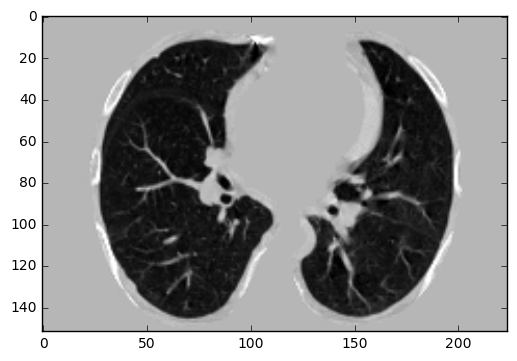

2017-02-18 21:36:22.134547 > [done]    generate_slice 112 (325.355 ms)
2017-02-18 21:36:22.134603 > [started] put patient image into dataset...
2017-02-18 21:36:22.249231 > [done]    put patient image into dataset (114.597 ms)
2017-02-18 21:36:22.262770 > [done]    >>> PATIENT PROCESSING 01f1140c8e951e2a921b61c9a7e782c2 (count=7; output_dir=../../output/step3/1/) (45977.205 ms)
2017-02-18 21:36:22.263121 Final dataset status
X shape= (8, 224, 152, 224)
Y shape= (8, 2)


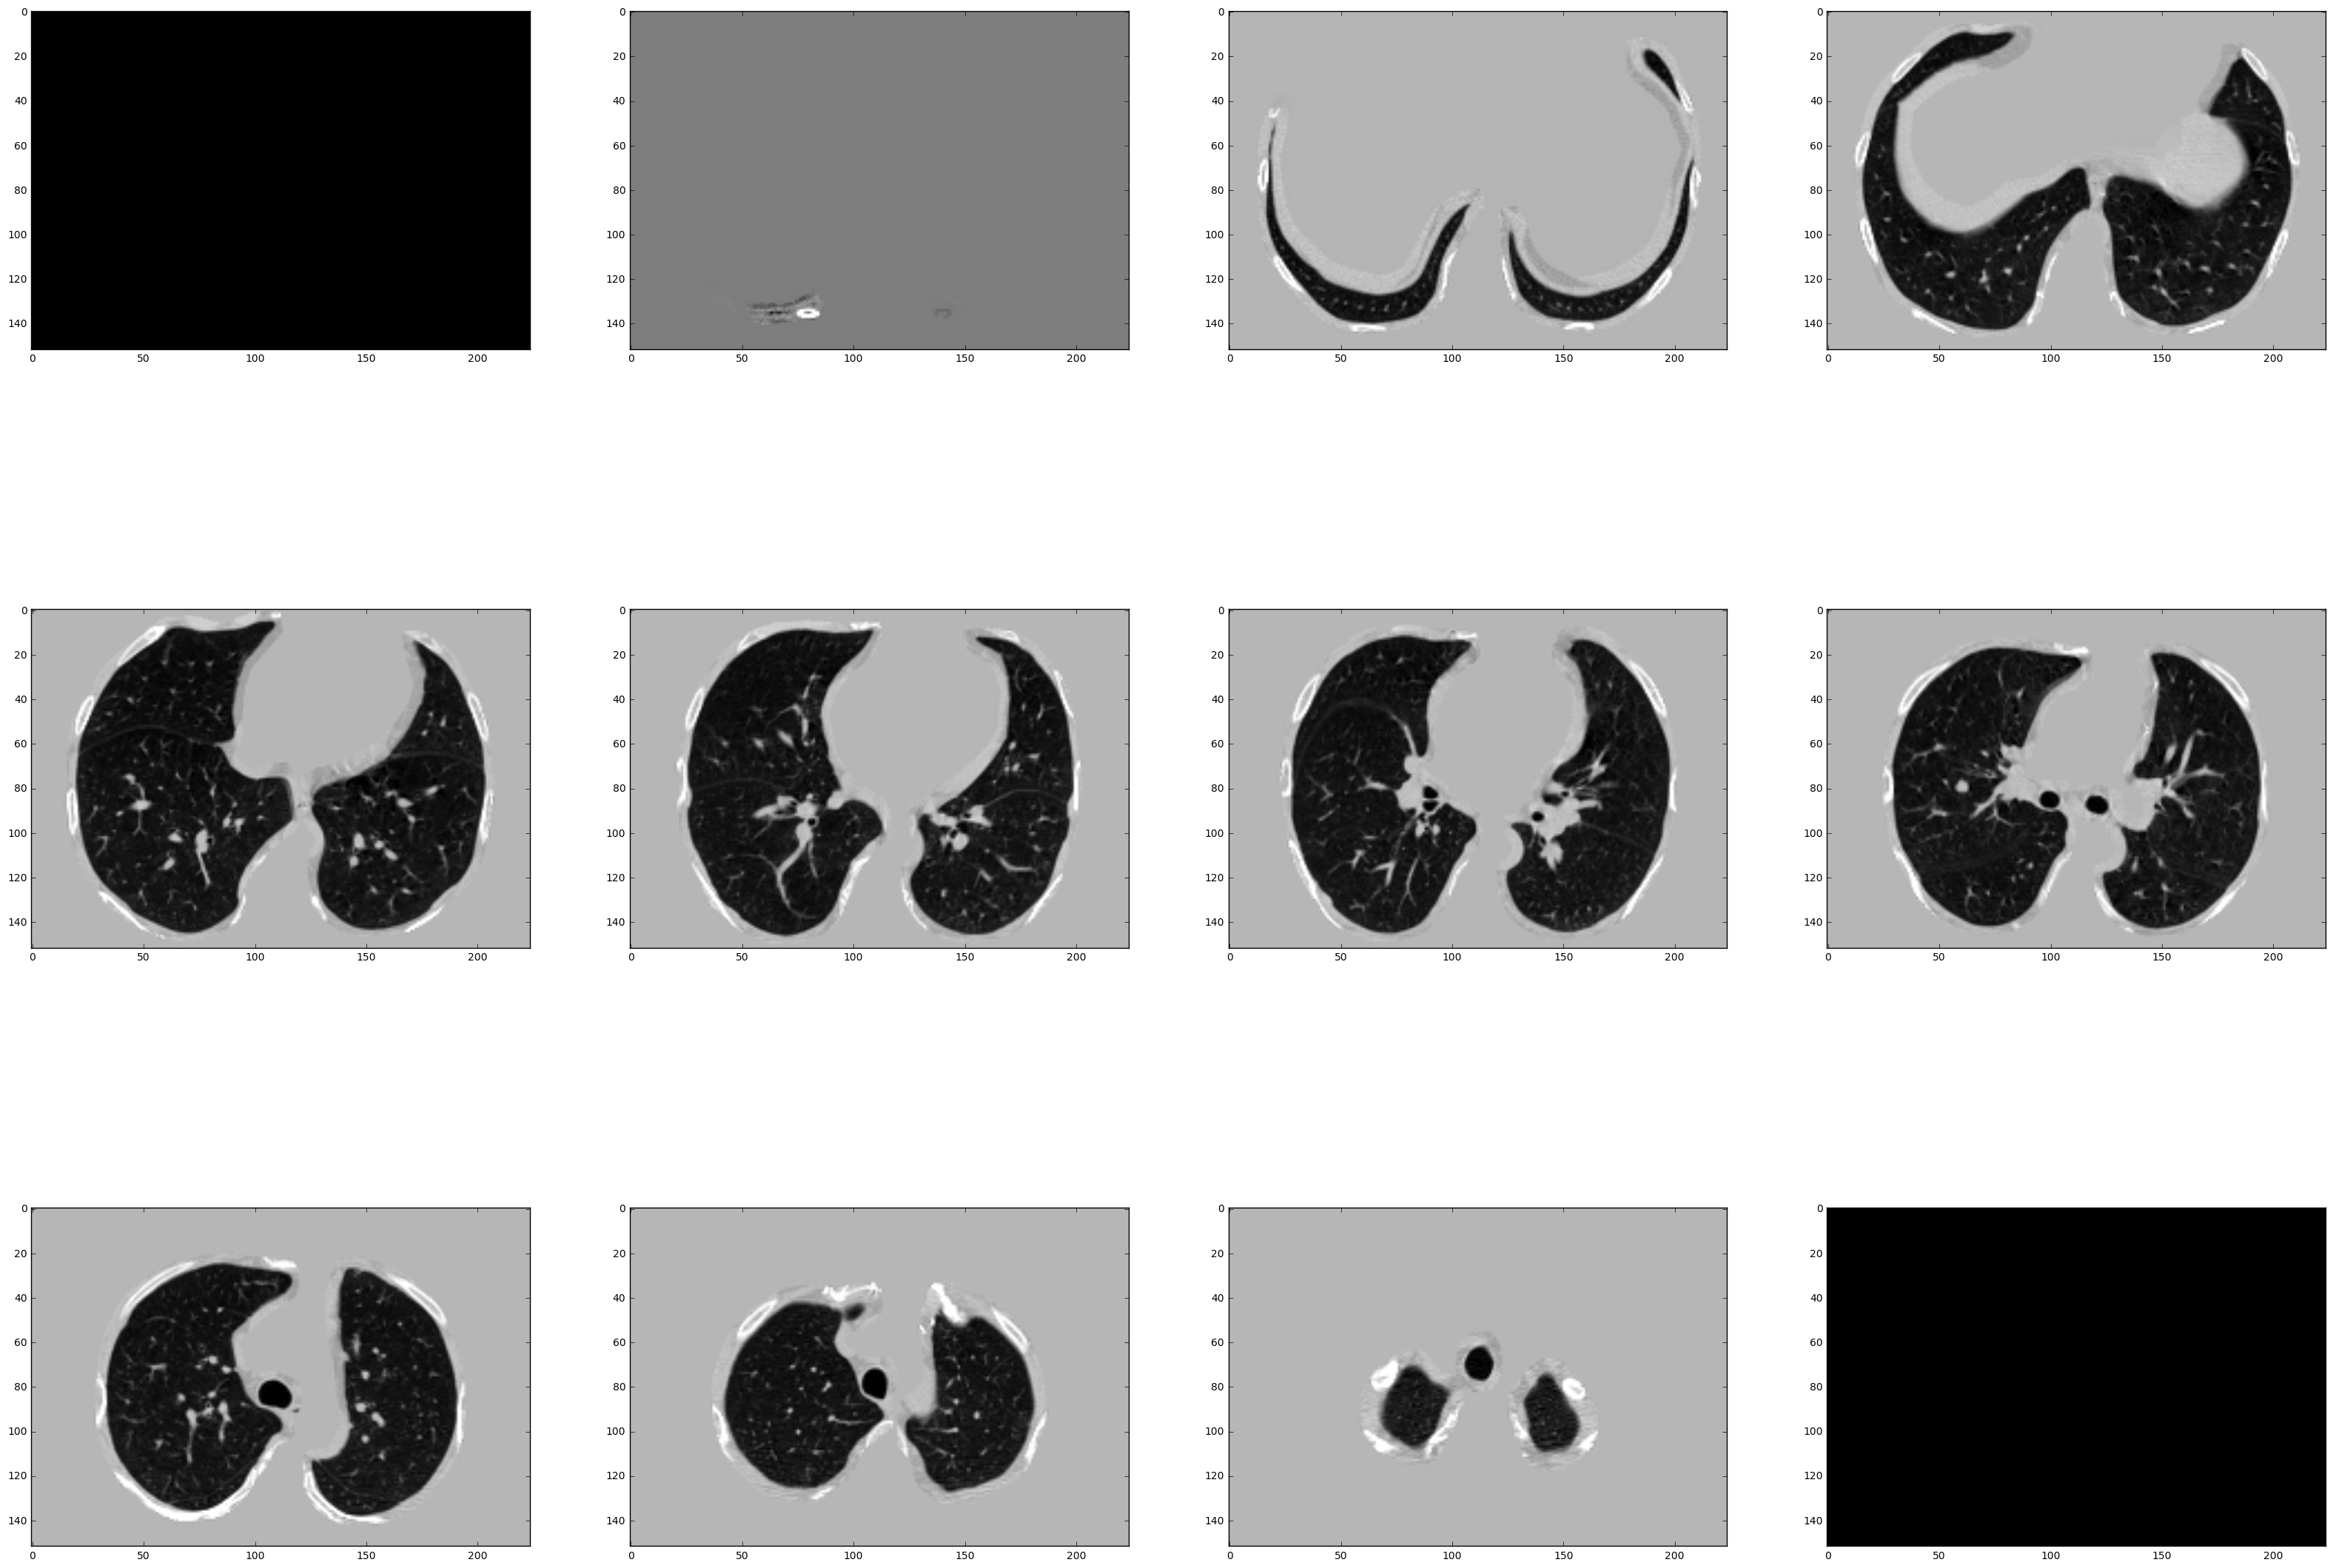

(224, 152, 224)
==== ALL DONE ====


In [97]:
print('==== PROCESSING SHARD ' + str(SHARD_ID) + ' ====')
start_processing(INPUT_FOLDER, SHARD_ID, 99, IMAGE_W, IMAGE_H, IMAGE_D, OUTPUT_FOLDER)
print('==== ALL DONE ====')